# **Prediction Model for Assessing Client Credit Eligibility**

# **FINAL TASK PROJECT BASED INTERNSHIP : Data Scientist - id/x Partners x Rakamin Academy**

## **Business Understanding**

**- Company Backround**

ID/X Partners adalah perusahaan konsultan yang telah beroperasi sejak tahun 2002, berfokus pada solusi Data Analytics and Decisioning (DAD) untuk manajemen risiko dan strategi pemasaran. Dalam setiap proyeknya, ID/X mengedepankan nilai inti CHAMPION, termasuk pengambilan keputusan berbasis data (Numeric), ketangkasan (Agility), dan inovasi (Innovative).

**- Project Overview**

Proyek ini bertujuan membangun model prediktif untuk mengklasifikasikan calon peminjam ke dalam dua kategori utama: High-Risk Loan dan Low-Risk Loan. Dengan pendekatan data-driven, model ini membantu perusahaan lending membuat keputusan kredit yang lebih akurat dan meminimalkan risiko gagal bayar.

**- Problem Statement**

Tingginya tingkat gagal bayar menjadi tantangan utama bagi perusahaan lending dalam menilai kelayakan kredit calon peminjam.
Kesalahan penilaian berdampak langsung pada kerugian finansial dan efisiensi operasional.

Melalui proyek "Prediction Model for Assessing Client Credit Eligibility", saya membangun solusi end-to-end berbasis data science untuk memprediksi risiko kredit sebelum pinjaman disetujui, Menyimulasikan dampak bisnis dari model prediktif, Menyampaikan hasil dalam bentuk visual yang informatif dan strategis.

**- Goals**

Membangun model prediksi risiko kredit guna mengurangi tingkat gagal bayar dan meningkatkan profitabilitas perusahaan lending.

**- Objective**

1. Mengklasifikasikan peminjam ke dalam kategori High-Risk Loan dan Low-Risk Loan.

2. Meningkatkan akurasi penilaian risiko sebelum pinjaman disetujui.

3. Mengukur dampak bisnis dari implementasi model prediktif terhadap revenue dan risiko.


**- Business Metrics**

1. High-Risk Rate – Default Rate (DR)

2. Total High-Risk Loans – Exposure at Default (EAD)

3. Total Revenue – Expected Interest Income (EII)

4. Total High-Risk Loss – Expected Loss (EL)

5. Net Revenue – Net Interest Income (NII)


[**Dataset Dictionary**](https://docs.google.com/spreadsheets/d/1iT1JNOBwU4l616_rnJpo0iny7blZvNBs/edit?gid=1666154857#gid=1666154857)


## **Import Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, f_oneway
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE

import re
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


file_path = '/content/drive/My Drive/loan_data_2007_2014.csv'
df = pd.read_csv(file_path, low_memory=True)  # Meminimalkan penggunaan memori
df_simulation = df.copy()
df.head()

# split data by rows and columns
rows = df.shape[0]
cols = df.shape[1]

Mounted at /content/drive


In [ ]:
# display data shape
print("Data shape:")
print(f"Number of rows: {rows} \nNumber of columns: {cols}")

Data shape:
Number of rows: 466285 
Number of columns: 75


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 75 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   466285 non-null  int64  
 1   id                           466285 non-null  int64  
 2   member_id                    466285 non-null  int64  
 3   loan_amnt                    466285 non-null  int64  
 4   funded_amnt                  466285 non-null  int64  
 5   funded_amnt_inv              466285 non-null  float64
 6   term                         466285 non-null  object 
 7   int_rate                     466285 non-null  float64
 8   installment                  466285 non-null  float64
 9   grade                        466285 non-null  object 
 10  sub_grade                    466285 non-null  object 
 11  emp_title                    438697 non-null  object 
 12  emp_length                   445277 non-null  object 
 13 

Analisis dataset menunjukkan bahwa terdapat 74 kolom dengan berbagai tipe data, termasuk float, integer, dan object, serta total 466.285 baris. Namun, beberapa kolom mengalami missing values, dan beberapa di antaranya sepenuhnya kosong. Temuan ini menekankan pentingnya pemrosesan data yang cermat untuk menjaga kualitas analisis.

## **Invalid Values**

In [ ]:
# Perbaiki fungsi untuk konversi full year
def convert_to_full_year_with_month(data_str):
    if pd.isnull(data_str):
        return None
    month, year = data_str.split('-')
    year = int(year)
    if year >= 40:  # Asumsikan data sebelum tahun 1940 tidak ada
        year_str = f'19{year}'
    else:
        year_str = f'20{year:02d}'
    return f'{month}-{year_str}'

In [ ]:
# Terapkan fungsi konversi ke setiap kolom
date_columns = ['issue_d', 'last_pymnt_d', 'earliest_cr_line', 'last_credit_pull_d']
for col in date_columns:
    df[col] = df[col].apply(convert_to_full_year_with_month)
    df[col] = pd.to_datetime(df[col], format='%b-%Y')

# **Data Pre-processing**

### **Data Cleansing**

#### **Handling Missing value**

#### **1. Empty Column**

In [ ]:
# Calculate null values
null_values = df.isnull().sum()

# Calculate total null values and percentage
nvc = pd.DataFrame(null_values.sort_values(), columns=['Total Null Values'])
nvc['Percentage'] = (nvc['Total Null Values'] / df.shape[0]) * 100
nvc["Data Type"] = [df[col].dtype for col in df.columns]
nvc.sort_values(by=["Total Null Values", "Percentage"], ascending=False, inplace=True)

# Display the results
nvc.style.background_gradient(cmap='Blues')

,Total Null Values,Percentage,Data Type
dti_joint,466285,100.000000,float64
annual_inc_joint,466285,100.000000,float64
open_acc_6m,466285,100.000000,float64
open_il_6m,466285,100.000000,float64
open_il_12m,466285,100.000000,float64
verification_status_joint,466285,100.000000,float64
open_il_24m,466285,100.000000,float64
mths_since_rcnt_il,466285,100.000000,float64
il_util,466285,100.000000,float64
total_bal_il,466285,100.000000,float64


In [ ]:
# display all the empty columns (no data)
mis_val = df.isna().sum()
empty_col = mis_val[mis_val == df.shape[0]]
empty_col

,0
annual_inc_joint,466285
dti_joint,466285
verification_status_joint,466285
open_acc_6m,466285
open_il_6m,466285
open_il_12m,466285
open_il_24m,466285
mths_since_rcnt_il,466285
total_bal_il,466285
il_util,466285


Terdapat 17 kolom bernilai kosong

In [ ]:
empty_col_names = empty_col.index # get all the empty column names
df = df.drop(columns=empty_col_names) # drop all empty columns

#### **2. Column Non-empty**

In [ ]:
# Fungsi untuk menghitung dan menampilkan kolom dengan nilai missing
def check_nan(df):
    # Hitung nilai null
    null_values = df.isnull().sum()

    # Buat DataFrame untuk total nilai null dan persentase
    nvc = pd.DataFrame(null_values[null_values > 0].sort_values(), columns=['Total Null Values'])  # Hanya ambil kolom dengan nilai null
    nvc['Percentage'] = (nvc['Total Null Values'] / df.shape[0]) * 100
    nvc["Data Type"] = [df[col].dtype for col in nvc.index]  # Ambil tipe data dari kolom yang ada

    # Urutkan berdasarkan total nilai null dan persentase
    nvc.sort_values(by=["Total Null Values", "Percentage"], ascending=False, inplace=True)

    # Tampilkan hasil dengan gaya
    return nvc.style.background_gradient(cmap='Blues')

# Panggil fungsi dan simpan hasilnya
styled_result = check_nan(df)

# Untuk menampilkan hasil di Jupyter Notebook, gunakan:
styled_result

,Total Null Values,Percentage,Data Type
mths_since_last_record,403647,86.566585,float64
mths_since_last_major_derog,367311,78.773926,float64
desc,340304,72.981975,object
mths_since_last_delinq,250351,53.690554,float64
next_pymnt_d,227214,48.728567,object
tot_coll_amt,70276,15.071469,float64
total_rev_hi_lim,70276,15.071469,float64
tot_cur_bal,70276,15.071469,float64
emp_title,27588,5.916553,object
emp_length,21008,4.505399,object


Kolom-kolom seperti title, desc, emp_title, dan emp_length yang memiliki nilai null dapat diisi dengan nilai seperti 'Unknown' atau 'Not Recorded', mengingat sifatnya yang sangat terpersonalisasi dan bergantung pada peminjam.

ada beberapa kolom yang memiliki jumlah null value nya sama
- `total_rev_hi_lim`, `tot_cur_bal`, dan `tot_coll_amnt` **70.276 baris**
- `delinq_2yrs`, `pub_rec`, `inq_last_6mths`, `open_acc`, `total_acc`, `earliest_cr_line`, dan `acc_now_delinq` **29 baris**

In [ ]:
# Pilih kolom yang memiliki 29 nilai missing
filtered_cols = df[['delinq_2yrs', 'pub_rec', 'inq_last_6mths', 'open_acc', 'total_acc', 'earliest_cr_line', 'acc_now_delinq']]

# Periksa apakah nilai null di setiap kolom berada di baris yang sama
missing_rows = filtered_cols[filtered_cols.isna().all(axis=1)]
display(missing_rows)

# Cetak total baris dengan nilai missing
print('\nTotal baris:', len(missing_rows))

,delinq_2yrs,pub_rec,inq_last_6mths,open_acc,total_acc,earliest_cr_line,acc_now_delinq
42449,NaN,NaN,NaN,NaN,NaN,NaT,NaN
42450,NaN,NaN,NaN,NaN,NaN,NaT,NaN
42459,NaN,NaN,NaN,NaN,NaN,NaT,NaN
42472,NaN,NaN,NaN,NaN,NaN,NaT,NaN
42480,NaN,NaN,NaN,NaN,NaN,NaT,NaN
42483,NaN,NaN,NaN,NaN,NaN,NaT,NaN
42494,NaN,NaN,NaN,NaN,NaN,NaT,NaN
42509,NaN,NaN,NaN,NaN,NaN,NaT,NaN
42514,NaN,NaN,NaN,NaN,NaN,NaT,NaN
42515,NaN,NaN,NaN,NaN,NaN,NaT,NaN



Total baris: 29


Missing value terdapat dalam baris yang sama, sehingga baris kosong ini akan dihapus.

In [ ]:
# Hapus baris yang memiliki nilai missing dari kolom yang telah difilter di atas
df = df.dropna(subset=filtered_cols.columns)

# Periksa kembali informasi nilai missing
check_nan(df)

,Total Null Values,Percentage,Data Type
mths_since_last_record,403618,86.565749,float64
mths_since_last_major_derog,367282,78.772606,float64
desc,340303,72.986299,object
mths_since_last_delinq,250322,53.687674,float64
next_pymnt_d,227214,48.731598,object
tot_cur_bal,70247,15.066187,float64
total_rev_hi_lim,70247,15.066187,float64
tot_coll_amt,70247,15.066187,float64
emp_title,27576,5.914347,object
emp_length,21008,4.505679,object


In [ ]:
filter_cols_mths = df[['mths_since_last_record', 'mths_since_last_major_derog', 'mths_since_last_delinq']]
filter_cols_mths.describe()

,mths_since_last_record,mths_since_last_major_derog,mths_since_last_delinq
count,62638.000000,98974.000000,215934.000000
mean,74.306012,42.852547,34.104430
std,30.357653,21.662591,21.778487
min,0.000000,0.000000,0.000000
25%,53.000000,26.000000,16.000000
50%,76.000000,42.000000,31.000000
75%,102.000000,59.000000,49.000000
max,129.000000,188.000000,188.000000


Semua kolom

In [ ]:
# Mengisi nilai missing dengan 0

## 1. Mengisi nilai missing di kolom mths_since_last_delinq untuk delinq_2yrs = 0
df.loc[(df['mths_since_last_delinq'].isna()) & (df['delinq_2yrs'] == 0.0), 'mths_since_last_delinq'] = 0

## 2. Mengisi nilai missing di kolom mths_since_last_record untuk pub_rec = 0
df.loc[(df['mths_since_last_record'].isna()) & (df['pub_rec'] == 0.0), 'mths_since_last_record'] = 0

## 3. Mengisi nilai missing di kolom mths_since_last_major_derog untuk pub_rec = 0 dan delinq_2yrs = 0
df.loc[(df['mths_since_last_major_derog'].isna()) & (df['pub_rec'] == 0.0) & (df['delinq_2yrs'] == 0.0), 'mths_since_last_major_derog'] = 0

berdasarkan asumsi logis:
Kalau seseorang tidak pernah mengalami suatu kejadian (misal menunggak, punya record, atau derogatori), maka wajar jika kolom tentang "berapa bulan sejak kejadian" itu kosong — dan itu bisa diisi dengan 0 (alias tidak pernah terjadi).

Ini adalah contoh rule-based imputation yang sangat berguna agar data tetap bersih dan tidak bias dalam modeling.

In [ ]:
# Mengisi nilai missing dengan -1 untuk data yang tidak diketahui
df[['mths_since_last_delinq', 'mths_since_last_major_derog']] = df[['mths_since_last_delinq', 'mths_since_last_major_derog']].fillna(-1)

Setelah melakukan imputasi 0 secara selektif sebelumnya (berdasarkan logika bahwa nasabah tidak pernah mengalami peristiwa tertentu), sisa missing values (NaN) yang tidak bisa dipastikan statusnya akan diisi dengan -1. Ini dilakukan untuk:

Nilai -1 bukan nilai aktual, tapi penanda bahwa sistem tidak tahu kapan terakhir kali kejadian itu terjadi.

Berbeda dari 0 yang berarti “tidak pernah terjadi”, nilai -1 ini menunjukkan bahwa kemungkinan pernah terjadi, tapi datanya tidak tersedia.

In [ ]:
# recheck missing values
check_nan(df)

,Total Null Values,Percentage,Data Type
desc,340303,72.986299,object
next_pymnt_d,227214,48.731598,object
tot_coll_amt,70247,15.066187,float64
tot_cur_bal,70247,15.066187,float64
total_rev_hi_lim,70247,15.066187,float64
emp_title,27576,5.914347,object
emp_length,21008,4.505679,object
last_pymnt_d,376,0.080642,datetime64[ns]
revol_util,311,0.066702,float64
collections_12_mths_ex_med,116,0.024879,float64


In [ ]:
# Periksa baris yang memiliki nilai null di kolom last_pymnt_d dengan informasi dari kolom lain
df.loc[df['last_pymnt_d'].isna(), ['last_pymnt_d', 'loan_status', 'last_credit_pull_d', 'last_pymnt_amnt', 'total_pymnt']]

,last_pymnt_d,loan_status,last_credit_pull_d,last_pymnt_amnt,total_pymnt
26,NaT,Charged Off,2016-01-01,0.0,0.00
2731,NaT,Charged Off,2016-01-01,0.0,0.00
3625,NaT,Charged Off,2012-04-01,0.0,366.75
3998,NaT,Charged Off,2016-01-01,0.0,0.00
4220,NaT,Charged Off,2016-01-01,0.0,1800.00
...,...,...,...,...,...
455499,NaT,Charged Off,2014-06-01,0.0,957.97
458391,NaT,Charged Off,2014-06-01,0.0,1144.13
459366,NaT,Charged Off,2016-01-01,0.0,0.00
464853,NaT,Charged Off,2014-06-01,0.0,1991.37


In [ ]:
# Periksa nilai unik dari loan_status di mana next_pymnt_d adalah null
df.loc[(df['next_pymnt_d'].isna()), 'loan_status'].value_counts()

,count
loan_status,
Fully Paid,184739
Charged Off,42475


In [ ]:
# Check unique values for specified columns
cols_to_check = ['last_pymnt_d', 'loan_status', 'last_credit_pull_d', 'last_pymnt_amnt', 'total_pymnt']
for col in cols_to_check:
    print(f"Unique values for column '{col}':")
    print(df[col].unique())
    print("-" * 20)


Unique values for column 'last_pymnt_d':
<DatetimeArray>
['2015-01-01 00:00:00', '2013-04-01 00:00:00', '2014-06-01 00:00:00',
 '2016-01-01 00:00:00', '2012-04-01 00:00:00', '2012-11-01 00:00:00',
 '2013-06-01 00:00:00', '2013-09-01 00:00:00', '2012-07-01 00:00:00',
 '2013-10-01 00:00:00', '2013-05-01 00:00:00', '2015-02-01 00:00:00',
 '2015-08-01 00:00:00', '2012-10-01 00:00:00', '2012-09-01 00:00:00',
                 'NaT', '2012-12-01 00:00:00', '2014-12-01 00:00:00',
 '2013-08-01 00:00:00', '2013-11-01 00:00:00', '2014-01-01 00:00:00',
 '2014-04-01 00:00:00', '2014-08-01 00:00:00', '2014-10-01 00:00:00',
 '2012-08-01 00:00:00', '2014-07-01 00:00:00', '2013-07-01 00:00:00',
 '2015-04-01 00:00:00', '2014-02-01 00:00:00', '2014-09-01 00:00:00',
 '2012-06-01 00:00:00', '2013-02-01 00:00:00', '2013-03-01 00:00:00',
 '2014-05-01 00:00:00', '2015-03-01 00:00:00', '2013-01-01 00:00:00',
 '2013-12-01 00:00:00', '2012-02-01 00:00:00', '2014-03-01 00:00:00',
 '2015-09-01 00:00:00', '2015-11-

In [ ]:
# Check unique values for 'next_pymnt_d'
print(df['next_pymnt_d'].unique())


[nan 'Feb-16' 'Jan-16' 'Sep-13' 'Feb-14' 'May-14' 'Jun-13' 'Mar-12'
 'Apr-12' 'May-13' 'Aug-12' 'Aug-13' 'Jun-12' 'Nov-13' 'Feb-12' 'Oct-11'
 'Jan-13' 'Jan-14' 'Jul-13' 'Jul-15' 'Jan-12' 'Dec-12' 'Jun-11' 'Feb-13'
 'Nov-11' 'Nov-12' 'Dec-11' 'Aug-11' 'Sep-11' 'Apr-11' 'Mar-14' 'Apr-13'
 'Mar-11' 'Jul-12' 'Aug-14' 'Oct-13' 'Sep-12' 'May-12' 'Apr-15' 'Jul-11'
 'Dec-15' 'Dec-13' 'Jan-11' 'Oct-12' 'Nov-14' 'Mar-13' 'Aug-15' 'Feb-15'
 'May-15' 'Jul-14' 'Nov-15' 'Sep-14' 'Oct-15' 'May-11' 'Feb-11' 'Dec-14'
 'Jun-15' 'Apr-14' 'Jan-15' 'Sep-15' 'Jun-14' 'Nov-10' 'Oct-10' 'Dec-10'
 'Mar-15' 'Oct-14' 'Jul-10' 'Sep-10' 'May-10' 'Aug-10' 'Mar-10' 'Jun-10'
 'Apr-10' 'Feb-10' 'Dec-09' 'Nov-09' 'Oct-09' 'Jan-10' 'Sep-09' 'Jun-09'
 'Aug-09' 'Jul-09' 'May-09' 'Apr-09' 'Jan-09' 'Oct-08' 'Feb-09' 'Nov-08'
 'Sep-08' 'Mar-09' 'Dec-08' 'Aug-08' 'Jun-08' 'Jul-08' 'Apr-08' 'May-08'
 'Feb-08' 'Jan-08' 'Mar-08' 'Dec-07' 'Mar-16']


In [ ]:
def replace_with_value(df, col_list):
    for col in col_list:
        # convert datetime to string
        if df[col].dtype == 'datetime64[ns]':
            df[col] = df[col].astype(str).replace('NaT', 'Not Recorded')

        # fill NaNs with 'Not Recorded'
        df[col] = df[col].fillna('Not Recorded')

        # special case: replace 'Not Recorded' with 'Loan Closed'
        if col == 'next_pymnt_d':
            df[col] = df[col].replace('Not Recorded', 'Loan Closed')

    return df

# function call
cat_cols_to_impute = ['title', 'desc', 'emp_title', 'emp_length', 'last_pymnt_d', 'last_credit_pull_d', 'next_pymnt_d']
replace_with_value(df, cat_cols_to_impute)

# recheck null values
check_nan(df)

,Total Null Values,Percentage,Data Type
tot_coll_amt,70247,15.066187,float64
tot_cur_bal,70247,15.066187,float64
total_rev_hi_lim,70247,15.066187,float64
revol_util,311,0.066702,float64
collections_12_mths_ex_med,116,0.024879,float64


In [ ]:
# Check unique values for 'next_pymnt_d'
print(df['next_pymnt_d'].unique())

['Loan Closed' 'Feb-16' 'Jan-16' 'Sep-13' 'Feb-14' 'May-14' 'Jun-13'
 'Mar-12' 'Apr-12' 'May-13' 'Aug-12' 'Aug-13' 'Jun-12' 'Nov-13' 'Feb-12'
 'Oct-11' 'Jan-13' 'Jan-14' 'Jul-13' 'Jul-15' 'Jan-12' 'Dec-12' 'Jun-11'
 'Feb-13' 'Nov-11' 'Nov-12' 'Dec-11' 'Aug-11' 'Sep-11' 'Apr-11' 'Mar-14'
 'Apr-13' 'Mar-11' 'Jul-12' 'Aug-14' 'Oct-13' 'Sep-12' 'May-12' 'Apr-15'
 'Jul-11' 'Dec-15' 'Dec-13' 'Jan-11' 'Oct-12' 'Nov-14' 'Mar-13' 'Aug-15'
 'Feb-15' 'May-15' 'Jul-14' 'Nov-15' 'Sep-14' 'Oct-15' 'May-11' 'Feb-11'
 'Dec-14' 'Jun-15' 'Apr-14' 'Jan-15' 'Sep-15' 'Jun-14' 'Nov-10' 'Oct-10'
 'Dec-10' 'Mar-15' 'Oct-14' 'Jul-10' 'Sep-10' 'May-10' 'Aug-10' 'Mar-10'
 'Jun-10' 'Apr-10' 'Feb-10' 'Dec-09' 'Nov-09' 'Oct-09' 'Jan-10' 'Sep-09'
 'Jun-09' 'Aug-09' 'Jul-09' 'May-09' 'Apr-09' 'Jan-09' 'Oct-08' 'Feb-09'
 'Nov-08' 'Sep-08' 'Mar-09' 'Dec-08' 'Aug-08' 'Jun-08' 'Jul-08' 'Apr-08'
 'May-08' 'Feb-08' 'Jan-08' 'Mar-08' 'Dec-07' 'Mar-16']


1. Datetime → string → isi "Not Recorded"

*  Konversi diperlukan karena NaT (Not a Time) pada datetime harus diubah menjadi string sebelum bisa diganti.

*  "Not Recorded" digunakan sebagai penanda eksplisit bahwa data tidak tersedia, tapi tidak berarti kosong/null dalam konteks modeling atau visualisasi.

2. Handling khusus untuk next_pymnt_d

*  Logika: kalau tidak ada tanggal pembayaran berikutnya, kemungkinan besar berarti pinjaman sudah lunas.

*  Jadi "Loan Closed" lebih informatif dan menggambarkan status aktual — bukan sekadar data kosong.

3. Untuk kolom kategorikal lain

* Contoh kolom seperti title, desc, emp_title, dan emp_length, jika kosong, dianggap tidak tercatat, jadi diisi dengan "Not Recorded".

In [ ]:
# drop the missing values
df = df.dropna(subset='collections_12_mths_ex_med')

tidak memiliki arti atau tidak bisa diimputasi dengan logika yang kuat, sehingga lebih aman dibuang saja.

In [ ]:
# check the correlation
df[['tot_coll_amt', 'collections_12_mths_ex_med', 'recoveries', 'collection_recovery_fee']].corr()

,tot_coll_amt,collections_12_mths_ex_med,recoveries,collection_recovery_fee
tot_coll_amt,1.000000,0.006721,-0.000625,-0.000309
collections_12_mths_ex_med,0.006721,1.000000,-0.001023,-0.000369
recoveries,-0.000625,-0.001023,1.000000,0.800703
collection_recovery_fee,-0.000309,-0.000369,0.800703,1.000000


In [ ]:
# check the correlation
df[['tot_coll_amt', 'collections_12_mths_ex_med', 'recoveries', 'collection_recovery_fee']].describe()

,tot_coll_amt,collections_12_mths_ex_med,recoveries,collection_recovery_fee
count,3.960090e+05,466140.000000,466140.000000,466140.000000
mean,1.919135e+02,0.009085,85.350950,8.959579
std,1.463021e+04,0.108648,552.252506,85.466870
min,0.000000e+00,0.000000,0.000000,0.000000
25%,0.000000e+00,0.000000,0.000000,0.000000
50%,0.000000e+00,0.000000,0.000000,0.000000
75%,0.000000e+00,0.000000,0.000000,0.000000
max,9.152545e+06,20.000000,33520.270000,7002.190000


In [ ]:
# impute with 0:
df['tot_coll_amt'] = df['tot_coll_amt'].fillna(0)

Kolom tot_coll_amt (Total Collection Amount) menunjukkan jumlah total tagihan yang masuk koleksi (penagihan pihak ketiga).

Jadi, ketika nilainya kosong (NaN), besar kemungkinan artinya adalah:

Nasabah tidak memiliki koleksi/tagihan yang masuk koleksi.

Sehingga secara logis dan aman, NaN dianggap = 0 (tidak punya utang koleksi).

In [ ]:
cols_to_describe = ['tot_cur_bal', 'total_pymnt', 'loan_amnt', 'revol_bal', 'out_prncp', 'installment', 'total_rec_int', 'total_rec_prncp', 'open_acc', 'total_acc']
description = df[cols_to_describe].describe()
description

,tot_cur_bal,total_pymnt,loan_amnt,revol_bal,out_prncp,installment,total_rec_int,total_rec_prncp,open_acc,total_acc
count,3.960090e+05,466140.000000,466140.000000,4.661400e+05,466140.000000,466140.000000,466140.000000,466140.000000,466140.000000,466140.000000
mean,1.388017e+05,11542.457531,14319.863614,1.623119e+04,4411.434160,432.136814,2589.199500,8867.258234,11.187562,25.066304
std,1.521147e+05,8265.960149,8286.085374,2.067188e+04,6355.591042,243.473002,2483.973276,7032.148339,4.987274,11.599131
min,0.000000e+00,0.000000,500.000000,0.000000e+00,0.000000,15.670000,0.000000,0.000000,0.000000,1.000000
25%,2.861800e+04,5553.597500,8000.000000,6.415000e+03,0.000000,256.820000,957.740000,3709.125000,8.000000,17.000000
50%,8.153900e+04,9421.340000,12000.000000,1.176600e+04,452.110000,380.040000,1819.135000,6819.925000,10.000000,23.000000
75%,2.089530e+05,15310.612500,20000.000000,2.033400e+04,7344.837500,566.660000,3305.062500,12000.000000,14.000000,32.000000
max,8.000078e+06,57777.579870,35000.000000,2.568995e+06,32160.380000,1409.990000,24205.620000,35000.030000,84.000000,156.000000


In [ ]:
# impute with median
cur_bal_median = df['tot_cur_bal'].median()
df['tot_cur_bal'] = df['tot_cur_bal'].fillna(cur_bal_median)

Kolom tot_cur_bal = Total Current Balance (jumlah saldo total saat ini dari semua akun).

Menggunakan median (nilai tengah) lebih aman dibandingkan mean karena tidak terpengaruh outlier.

In [ ]:
df['rev_lim_bal_ratio'] = df['total_rev_hi_lim'] / df['revol_bal']
median_ratio = df['rev_lim_bal_ratio'].median()

# impute total_rev_hi_lim with the median ratio
df.loc[df['total_rev_hi_lim'].isna(), 'total_rev_hi_lim'] = df['revol_bal'] * median_ratio

df = df.drop('rev_lim_bal_ratio', axis=1)

Menggunakan data relasional antar kolom, membuat hasilnya lebih masuk akal.

In [ ]:
# recheck missing values
check_nan(df)

,Total Null Values,Percentage,Data Type
revol_util,308,0.066075,float64


In [ ]:
# check the correlation between these columns
df[['revol_util', 'revol_bal', 'dti', 'int_rate', 'total_rec_int']].corr()

,revol_util,revol_bal,dti,int_rate,total_rec_int
revol_util,1.000000,0.206663,0.200338,0.323271,0.209634
revol_bal,0.206663,1.000000,0.143394,-0.004635,0.207024
dti,0.200338,0.143394,1.000000,0.159461,0.089386
int_rate,0.323271,-0.004635,0.159461,1.000000,0.485094
total_rec_int,0.209634,0.207024,0.089386,0.485094,1.000000


In [ ]:
# check the null rows in revol_util where the value of revol_bal = 0
df.loc[(df['revol_util'].isna()) & (df['revol_bal'] == 0), ['revol_util', 'revol_bal', 'total_rev_hi_lim']]

,revol_util,revol_bal,total_rev_hi_lim
3577,NaN,0,0.0
4730,NaN,0,0.0
4960,NaN,0,0.0
11315,NaN,0,0.0
12076,NaN,0,0.0
...,...,...,...
449512,NaN,0,0.0
451515,NaN,0,0.0
459356,NaN,0,0.0
464273,NaN,0,0.0


In [ ]:
rev_util_formula = (df['revol_bal'] / df['total_rev_hi_lim']) * 100 # revol util formula

# impute using formula if both revol_bal and total_rev_hi_lim > 0
df.loc[df['revol_util'].isna(), 'revol_util'] = rev_util_formula

# impute the rest with 0
df['revol_util'] = df['revol_util'].fillna(0)

Revolving Utilization = persentase penggunaan batas kredit (mirip seperti credit card utilization).

Karena kolom revol_util berisi persentase penggunaan kredit, maka nilai kosong (missing) sebaiknya diisi dengan logika yang masuk akal,

In [ ]:
# recheck null values
check_nan(df)

,Total Null Values,Percentage,Data Type


#### **Handling Duplicated Data**

In [ ]:
# Mengecek apakah ada duplikat di setiap baris
duplicates = df.duplicated()

# Menampilkan jumlah duplikat dan baris yang duplikat
print(f"Jumlah baris duplikat: {duplicates.sum()}")
print("Baris yang duplikat:")
print(df[duplicates])

Jumlah baris duplikat: 0
Baris yang duplikat:
Empty DataFrame
Columns: [Unnamed: 0, id, member_id, loan_amnt, funded_amnt, funded_amnt_inv, term, int_rate, installment, grade, sub_grade, emp_title, emp_length, home_ownership, annual_inc, verification_status, issue_d, loan_status, pymnt_plan, url, desc, purpose, title, zip_code, addr_state, dti, delinq_2yrs, earliest_cr_line, inq_last_6mths, mths_since_last_delinq, mths_since_last_record, open_acc, pub_rec, revol_bal, revol_util, total_acc, initial_list_status, out_prncp, out_prncp_inv, total_pymnt, total_pymnt_inv, total_rec_prncp, total_rec_int, total_rec_late_fee, recoveries, collection_recovery_fee, last_pymnt_d, last_pymnt_amnt, next_pymnt_d, last_credit_pull_d, collections_12_mths_ex_med, mths_since_last_major_derog, policy_code, application_type, acc_now_delinq, tot_coll_amt, tot_cur_bal, total_rev_hi_lim]
Index: []

[0 rows x 58 columns]


## **Handling Outlier**

In [ ]:
print(df['policy_code'])

0         1
1         1
2         1
3         1
4         1
         ..
466280    1
466281    1
466282    1
466283    1
466284    1
Name: policy_code, Length: 466140, dtype: int64


In [ ]:
df = df.drop(columns=['Unnamed: 0', 'id', 'member_id','policy_code'], errors='ignore')


In [ ]:
# Get numerical columns from the DataFrame 'df'
num_columns = df.select_dtypes(include=['number']).columns

# Now you can use 'num_columns' as intended
num_columns # numerical columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate',
       'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'mths_since_last_delinq', 'mths_since_last_record', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
       'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_amnt',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim'],
      dtype='object')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

def plot_outliers(df, num_cols, cols_per_row=4, row_height=4, col_width=5):
    total = len(num_cols)
    rows = math.ceil(total / cols_per_row)
    figsize = (col_width * cols_per_row, row_height * rows)

    plt.style.use('default')  # Background putih
    fig, axes = plt.subplots(rows, cols_per_row, figsize=figsize)
    axes = axes.flatten()

    for i, col in enumerate(num_cols):
        sns.boxplot(y=df[col], ax=axes[i], color='steelblue', linewidth=1)
        axes[i].set_title(f'{col}', fontsize=10)
        axes[i].set_ylabel('')
        axes[i].grid(True, linestyle='--', alpha=0.5)

    # Hapus subplot kosong
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.suptitle('Boxplots of Numerical Features', fontsize=14, y=1.02)
    plt.show()

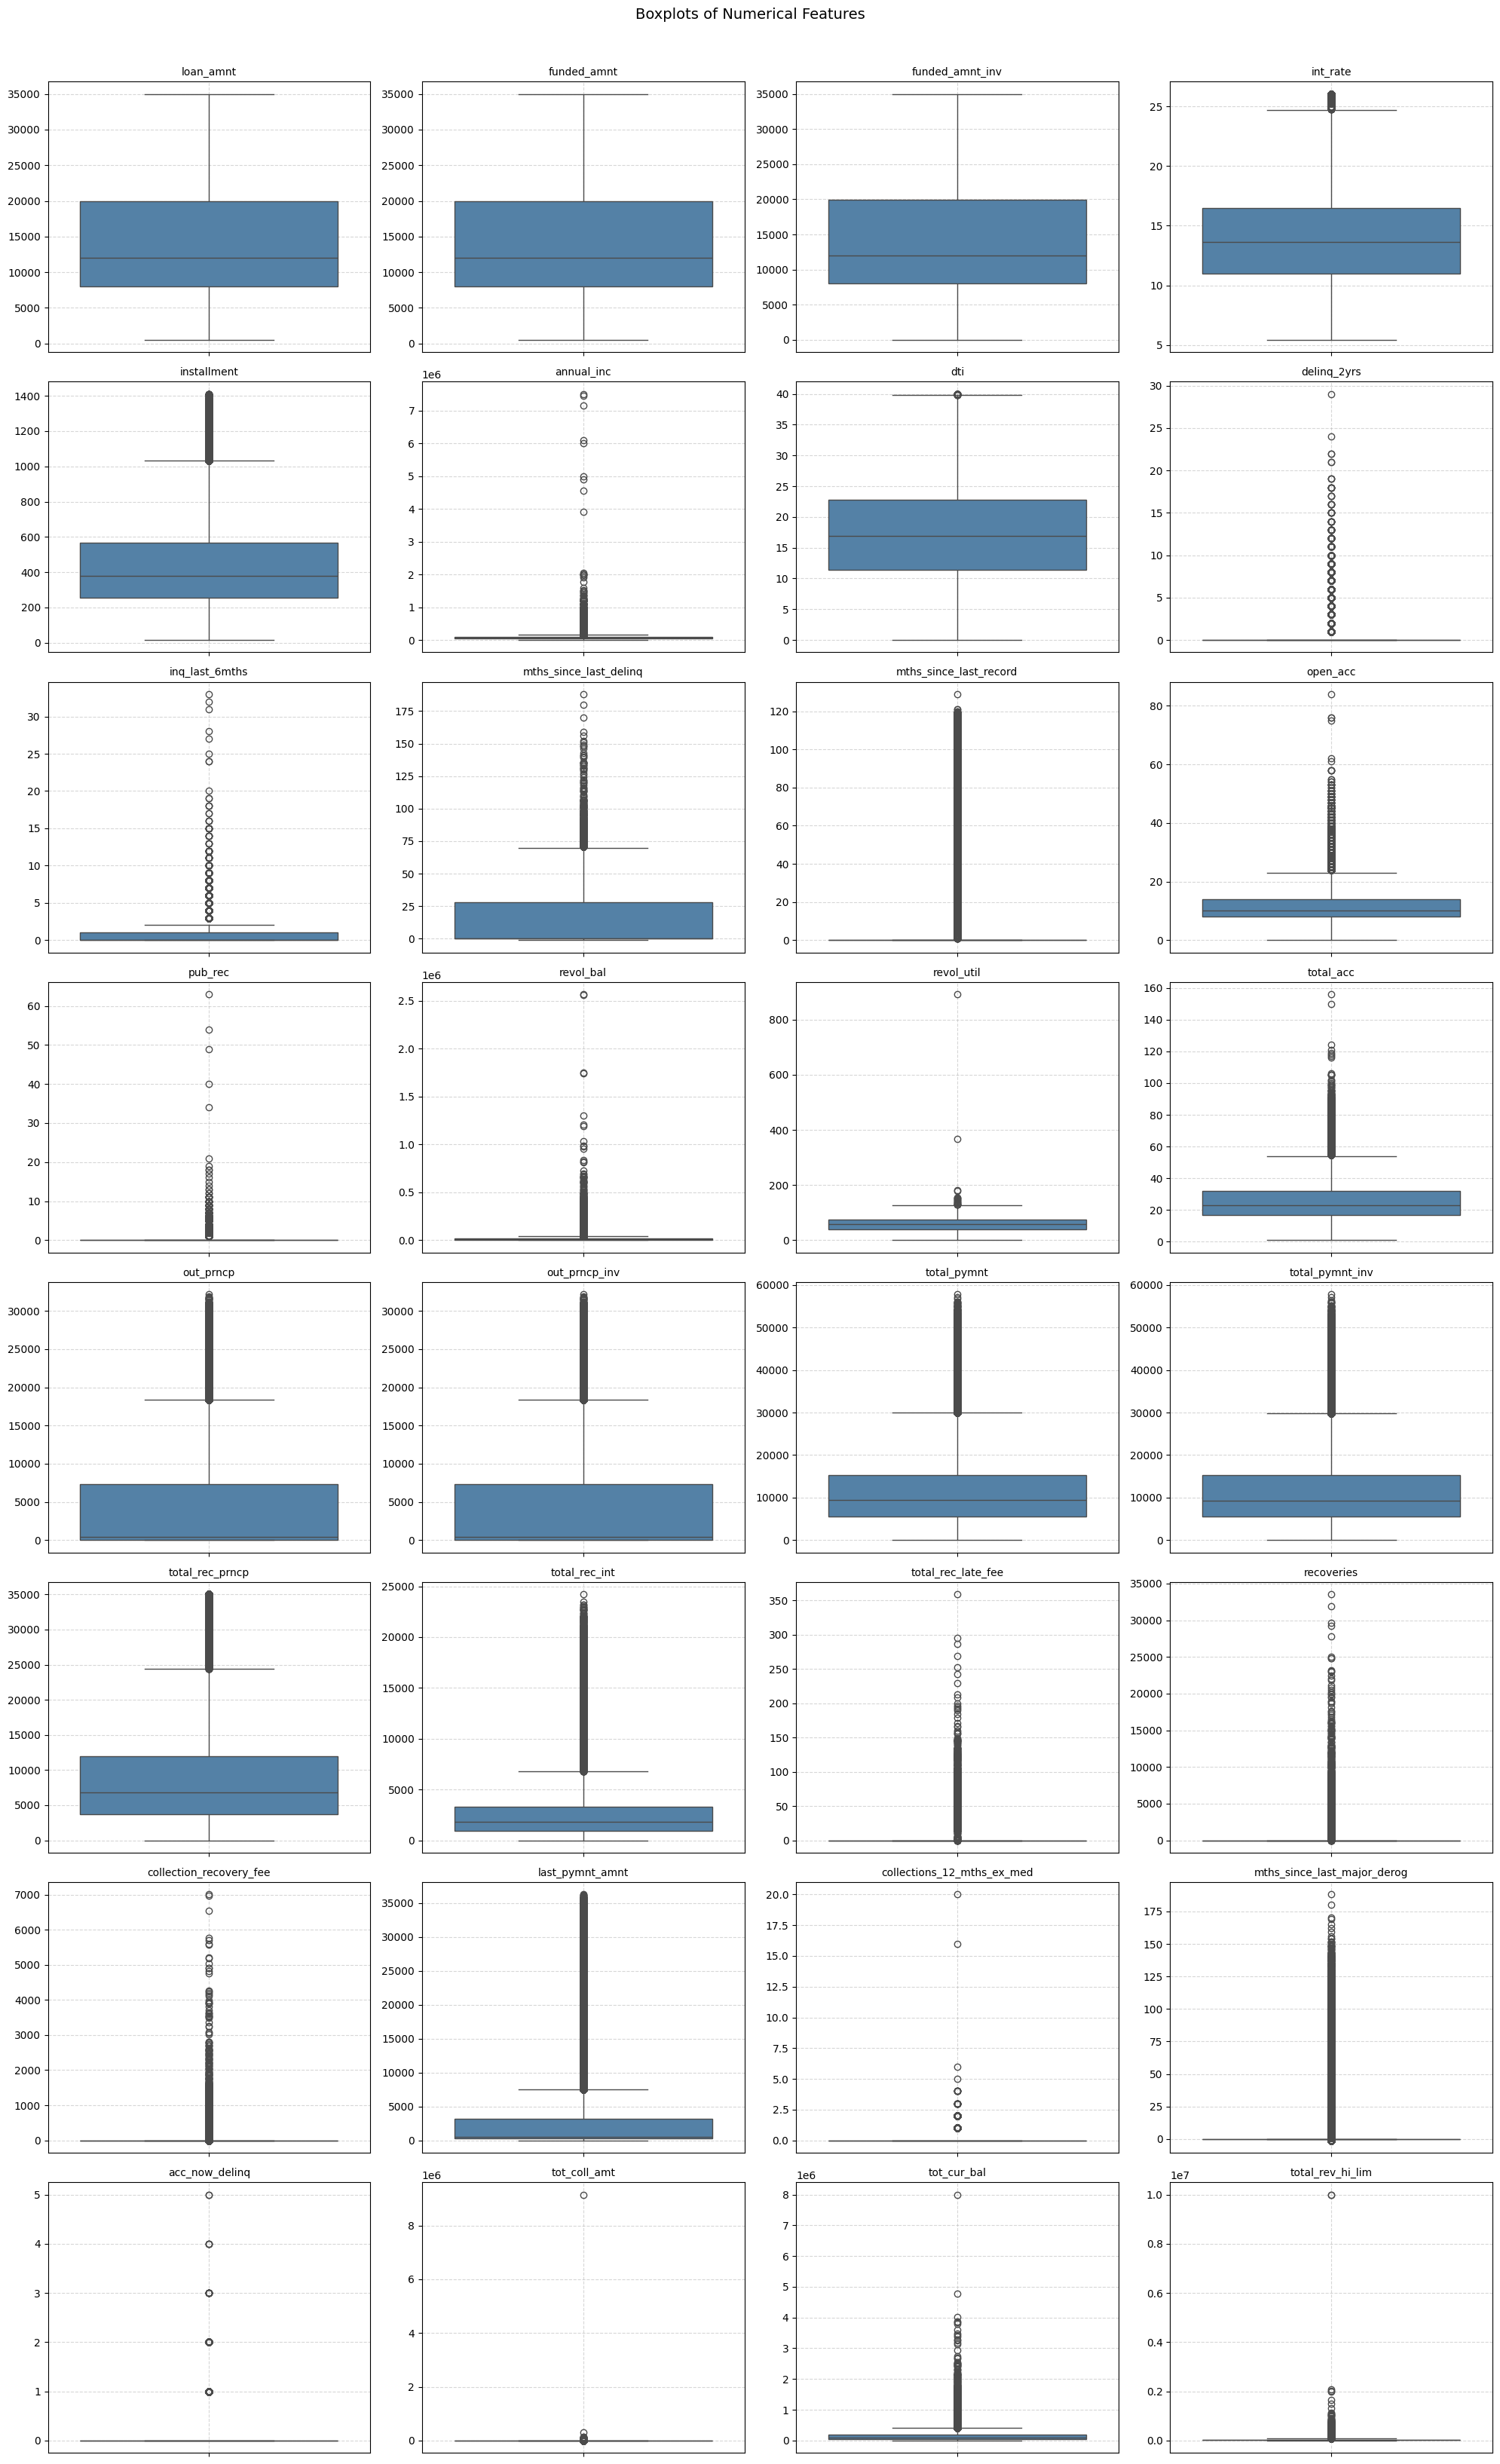

In [ ]:
# function call
plot_outliers(df, num_columns)

Untuk outlier akan di lakukan metode Capping oleh karena itu kita butuh summary outlier tahu batas bawah/atas dan bersiap untuk trimming atau capping IQR

In [ ]:
def outliers_info(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 1.5 * IQR
    lower_bound = Q1 - 1.5 * IQR

    count = ((series < lower_bound) | (series > upper_bound)).sum()
    return count, upper_bound, lower_bound

In [ ]:
def print_outliers(df, num_cols):
    outliers_dict = {}  # store the column name and the number of outliers present

    for col in num_cols:
        count, upper, lower = outliers_info(df[col])  # gunakan variabel baru

        if count > 0:
            outliers_dict[col] = count  # simpan hanya kolom yang punya outlier

    # Sort hasilnya dari yang paling banyak outlier
    sorted_outliers = dict(sorted(outliers_dict.items(), key=lambda item: item[1], reverse=True))

    # Tampilkan
    for col, val in sorted_outliers.items():
        print(f'Total outliers in {col}: {val} ({((val/len(df)) * 100):.2f}%)')

    print(f'\nTotal columns with outliers: {len(sorted_outliers)} out of {len(num_cols)}')

In [ ]:
print_outliers(df, num_columns)

Total outliers in mths_since_last_major_derog: 183624 (39.39%)
Total outliers in delinq_2yrs: 83281 (17.87%)
Total outliers in last_pymnt_amnt: 70287 (15.08%)
Total outliers in pub_rec: 61352 (13.16%)
Total outliers in mths_since_last_record: 61349 (13.16%)
Total outliers in tot_coll_amt: 49750 (10.67%)
Total outliers in inq_last_6mths: 36754 (7.88%)
Total outliers in total_rec_int: 31133 (6.68%)
Total outliers in total_rev_hi_lim: 25714 (5.52%)
Total outliers in recoveries: 24352 (5.22%)
Total outliers in out_prncp_inv: 23326 (5.00%)
Total outliers in out_prncp: 23319 (5.00%)
Total outliers in collection_recovery_fee: 23187 (4.97%)
Total outliers in revol_bal: 22869 (4.91%)
Total outliers in tot_cur_bal: 21064 (4.52%)
Total outliers in total_rec_prncp: 20648 (4.43%)
Total outliers in annual_inc: 19885 (4.27%)
Total outliers in total_pymnt_inv: 19037 (4.08%)
Total outliers in total_pymnt: 19020 (4.08%)
Total outliers in mths_since_last_delinq: 16767 (3.60%)
Total outliers in installmen

Dengan 29 dari 32 kolom mengandung outliers, dan beberapa lebih dari 30% nilainya outlier, capping dengan IQR adalah pendekatan paling aman, efisien, dan efektif untuk menjaga kualitas data tanpa kehilangan banyak informasi.

Kalau langsung di-drop, akan kehilangan sebagian besar data, dan itu bisa bikin model jadi underfit atau tidak representatif.

In [ ]:
def cap_outliers(df, num_cols):
  for col in num_cols:
    _, upper_bound, lower_bound = outliers_info(df[col])  # Ambil batas atas & bawah via IQR
    df[col] = df[col].clip(lower_bound, upper_bound)      # Potong (clip) nilai ekstrem
  return df

In [ ]:
# function call
df_capped = cap_outliers(df, num_columns)

# recheck outliers
print_outliers(df_capped, num_columns)


Total columns with outliers: 0 out of 32


data sekarang telah bebas dari outlier setelah proses capping, dan siap digunakan untuk tahap berikutnya

In [ ]:
# #boxplot after capping
# plot_outliers(df_capped, num_columns)

##**Labelling**


In [ ]:
loan_status_counts = df_capped['loan_status'].value_counts()
loan_status_counts

,count
loan_status,
Current,224226
Fully Paid,184689
Charged Off,42469
Late (31-120 days),6900
In Grace Period,3146
Does not meet the credit policy. Status:Fully Paid,1921
Late (16-30 days),1218
Default,832
Does not meet the credit policy. Status:Charged Off,739


Penjelasan mengenai nilai dari loan_status :

* Fully Paid = Pinjaman telah dilunasi sepenuhnya oleh peminjam.

* Charged Off = Pinjaman dianggap tidak tertagih karena gagal bayar dalam jangka waktu lama.

* Current = Pinjaman masih berjalan, dan peminjam melakukan pembayaran sesuai jadwal.

* Default = Pinjaman telah melewati batas keterlambatan tertentu dan dianggap gagal bayar permanen.

* Late (31-120 days) = Pembayaran telah terlambat antara 31 hingga 120 hari.

* In Grace Period = Peminjam melewati tanggal jatuh tempo tetapi masih dalam masa tenggang sebelum dianggap terlambat.

* Late (16-30 days) = Pembayaran tertunda antara 16 hingga 30 hari.

* Does not meet the credit policy. Status: Fully Paid = Tidak memenuhi kebijakan kredit tetapi berhasil melunasi pinjaman.

* Does not meet the credit policy. Status: Charged Off = Tidak memenuhi kebijakan kredit dan akhirnya gagal bayar.

Dalam analisis ini, fitur loan_status dipilih sebagai label target karena memiliki nilai yang jelas dan informatif, seperti Fully Paid, Current, Default, Charged Off, dan lainnya. Untuk memahami pola kredit dengan lebih baik, status pinjaman ini dikelompokkan ke dalam dua kategori utama:

> **Low-Risk Loan**: Mencakup pinjaman yang menunjukkan rekam jejak pembayaran yang baik, seperti **Fully Paid, Current, dan Does not meet the credit policy (Fully Paid)**.

> **High-Risk Loan**: Mencakup pinjaman yang memiliki risiko gagal bayar tinggi, seperti **Default, Charged Off, Late (31-120 days), Late (16-30 days), Does not meet the credit policy (Charged Off), dan In Grace Period**.

Sehingga dalam proses selanjutnya dilakukan visualisasi distribusi status pinjaman dan menganalisis total jumlah pinjaman yang diterima berdasarkan setiap kategori. Hal ini akan membantu dalam mengidentifikasi pola pembayaran dan memahami kategori mana yang mendominasi dalam jumlah pinjaman yang diberikan.

In [ ]:
# Mapping status as high-risk or low-risk
def map_loan_status(status):
    """
    Fungsi untuk mengelompokkan status pinjaman menjadi 'high-risk' atau 'low-risk'.
    """
    default_statuses = [
        'Charged Off',
        'Late (31-120 days)',
        'Late (16-30 days)',
        'In Grace Period',
        'Default',
        'Does not meet the credit policy. Status:Charged Off'
    ]
    return 'high-risk' if status in default_statuses else 'low-risk'

# Apply mapping: hasilnya akan jadi string 'high-risk' atau 'low-risk'
df_capped['loan_status'] = df_capped['loan_status'].apply(map_loan_status)

# Encode hasil mapping langsung ke angka: 'high-risk' = 1, 'low-risk' = 0
df_capped['loan_status'] = df_capped['loan_status'].map({'low-risk': 0, 'high-risk': 1})
print(df_capped['loan_status'].head(10))

0    0
1    1
2    0
3    0
4    0
5    0
6    0
7    0
8    1
9    1
Name: loan_status, dtype: int64


## **Feature Engineering**

### **Create New Feature**

In [ ]:
# Konversi semua kolom tanggal ke datetime (jika belum)
date_cols = ['issue_d', 'last_pymnt_d', 'last_credit_pull_d', 'earliest_cr_line']
for col in date_cols:
    if col in df_capped.columns:
        df_capped[col] = pd.to_datetime(df_capped[col], errors='coerce')


In [ ]:
# Ekstrak informasi waktu dari issue_d
df_capped['issue_year'] = df_capped['issue_d'].dt.year
df_capped['issue_month'] = df_capped['issue_d'].dt.month

# Menghitung payment_time dalam bulan
df_capped['payment_time'] = (df_capped['last_pymnt_d'].dt.year - df_capped['issue_d'].dt.year) * 12 + \
                            (df_capped['last_pymnt_d'].dt.month - df_capped['issue_d'].dt.month)

# Menghitung loan_time dalam bulan
df_capped['loan_time'] = (df_capped['last_credit_pull_d'].dt.year - df_capped['earliest_cr_line'].dt.year) * 12 + \
                         (df_capped['last_credit_pull_d'].dt.month - df_capped['earliest_cr_line'].dt.month)

# Hapus kolom yang menyebabkan data leakage
df_capped.drop(columns=['earliest_cr_line', 'issue_d', 'last_pymnt_d', 'last_credit_pull_d'], inplace=True)

1. Ekstraksi Informasi Waktu dari issue_d

Bisa digunakan untuk analisis tren pinjaman berdasarkan tahun dan musim (misalnya: apakah lebih banyak pinjaman diajukan di awal tahun atau akhir tahun?).

2. Menghitung payment_time dalam Bulan

Bisa digunakan untuk memahami seberapa lama seseorang membayar pinjamannya.

3. Menghitung loan_time dalam Bulan

Bisa digunakan untuk memahami seberapa aktif peminjam dalam sistem kredit.

In [ ]:
# Recheck null values
check_nan(df_capped)

,Total Null Values,Percentage,Data Type
payment_time,376,0.080662,float64
loan_time,40,0.008581,float64


In [ ]:
# Assuming 'df' is your DataFrame (as defined in the provided code)
df_capped[['payment_time', 'loan_time']].describe()

,payment_time,loan_time
count,465764.000000,466100.000000
mean,19.952637,215.460646
std,9.541314,87.534422
min,0.000000,16.000000
25%,14.000000,156.000000
50%,18.000000,198.000000
75%,26.000000,259.000000
max,70.000000,864.000000


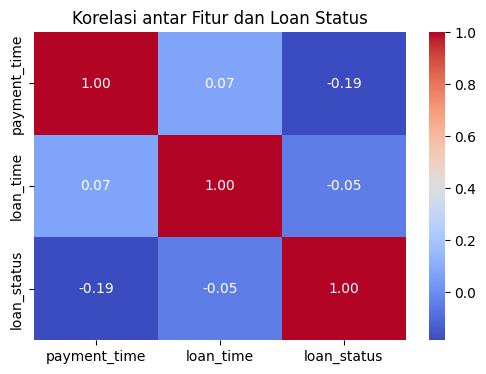

payment_time   -0.186116
loan_time      -0.048051
loan_status     1.000000
Name: loan_status, dtype: float64


In [ ]:
# Pilih kolom numerik yang ingin dihitung korelasinya
corr_cols = ['payment_time', 'loan_time', 'loan_status']
corr_matrix = df_capped[corr_cols].corr()

# Visualisasi heatmap korelasi
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Korelasi antar Fitur dan Loan Status")
plt.show()

# Nilai korelasi langsung terhadap target
print(corr_matrix['loan_status'])

* payment_time masih cukup layak disimpan, karena korelasi mendekati -0.2. Bisa diuji nanti di modeling.

* loan_time punya korelasi lemah banget,
drop dari awal untuk menjaga fitur tetap ringkas



In [ ]:
# Isi NaN pada payment_time dengan median
df_capped['payment_time'].fillna(df_capped['payment_time'].median(), inplace=True)

# Hapus kolom loan_time karena korelasinya rendah dan dianggap kurang relevan
df_capped.drop('loan_time', axis=1, inplace=True)

# Recheck null values
check_nan(df_capped)

,Total Null Values,Percentage,Data Type


####**Buang Kolom Redundan & High Cardinality**

In [ ]:
# Memilih kolom dengan tipe data numerik
numeric_columns = df_capped.select_dtypes(include=['number']).columns
numeric_columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate',
       'installment', 'annual_inc', 'loan_status', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_amnt',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim',
       'issue_year', 'issue_month', 'payment_time'],
      dtype='object')

In [ ]:
df_capped.select_dtypes('object').columns

Index(['term', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'verification_status', 'pymnt_plan', 'url', 'desc',
       'purpose', 'title', 'zip_code', 'addr_state', 'initial_list_status',
       'next_pymnt_d', 'application_type'],
      dtype='object')

In [ ]:
# Daftar kolom kategoric dengan Redundan dan high cardinality
high_card_cols = ['emp_title', 'url', 'desc', 'title',
                  'zip_code', 'next_pymnt_d','application_type']
df_capped = df_capped.drop(columns=high_card_cols)

In [ ]:
print(df_capped.columns)

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'loan_status', 'pymnt_plan',
       'purpose', 'addr_state', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'mths_since_last_delinq', 'mths_since_last_record', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_amnt', 'collections_12_mths_ex_med',
       'mths_since_last_major_derog', 'acc_now_delinq', 'tot_coll_amt',
       'tot_cur_bal', 'total_rev_hi_lim', 'issue_year', 'issue_month',
       'payment_time'],
      dtype='object')


Beberapa kolom seperti url, desc, title, emp_title, dan zip_code memiliki terlalu banyak nilai unik (high cardinality) atau tidak memberikan informasi yang berguna untuk prediksi. Kolom seperti id, member_id, dan Unnamed: 0 juga tidak punya nilai prediktif dan hanya menjadi noise. Maka dari itu, kolom-kolom ini dihapus agar model lebih efisien dan akurat.

In [ ]:
df_capped.select_dtypes('object').columns

Index(['term', 'grade', 'sub_grade', 'emp_length', 'home_ownership',
       'verification_status', 'pymnt_plan', 'purpose', 'addr_state',
       'initial_list_status'],
      dtype='object')

#### **Create state_region based addr_state**

In [ ]:
# Definisikan mapping
regions = {
    'West':     ['CA', 'NV', 'UT', 'CO', 'WY', 'MT', 'ID', 'OR', 'WA', 'AK', 'HI'],
    'Southwest':['AZ', 'NM', 'TX', 'OK'],
    'Midwest':  ['ND', 'MN', 'SD', 'NE', 'KS', 'MO', 'IA', 'WI', 'IL', 'IN', 'OH', 'MI'],
    'Southeast':['AR', 'LA', 'MS', 'AL', 'GA', 'TN', 'KY', 'NC', 'SC', 'WV', 'DC', 'VA', 'DE', 'FL'],
    'Northeast':['PA', 'MD', 'NJ', 'NY', 'CT', 'RI', 'MA', 'NH', 'VT', 'ME']
}

# Inisialisasi kolom baru
df_capped['state_region'] = 'Unknown'

# Looping dan assign nilai
for region, states in regions.items():
    df_capped.loc[df_capped['addr_state'].isin(states), 'state_region'] = region

df_capped.drop(columns=['addr_state'], inplace=True)

In [ ]:
# tampilkan hasil
display(df_capped[['state_region']])

,state_region
0,Southwest
1,Southeast
2,Midwest
3,West
4,West
...,...
466280,Southwest
466281,Southeast
466282,Midwest
466283,West


Menyederhanakan visualisasi (dari 50+ state jadi hanya 5 region)

#### **Create grouped_purpose based purpose**

In [ ]:
# definisikan fungsi custom
def group_purpose(purpose):
    if purpose in ['credit_card', 'debt_consolidation']:
        return 'Debt Management'
    elif purpose in ['small_business', 'educational']:
        return 'Business & Education'
    elif purpose in ['home_improvement', 'house', 'renewable_energy', 'major_purchase', 'car']:
        return 'Home & Major Purchases'
    elif purpose in ['medical', 'moving', 'vacation', 'wedding']:
        return 'Personal & Lifestyle'
    elif purpose == 'other':
        return 'Other'
    else:
        return 'Unknown'

# apply ke kolom
df_capped['grouped_purpose'] = df_capped['purpose'].apply(group_purpose)

# tampilkan hasil
display(df_capped[['purpose', 'grouped_purpose']])

# hapus kolom asal jika perlu
df_capped = df_capped.drop(columns=['purpose'])


,purpose,grouped_purpose
0,credit_card,Debt Management
1,car,Home & Major Purchases
2,small_business,Business & Education
3,other,Other
4,other,Other
...,...,...
466280,debt_consolidation,Debt Management
466281,debt_consolidation,Debt Management
466282,debt_consolidation,Debt Management
466283,credit_card,Debt Management


Mengelompokkan nilai pada kolom purpose (yang banyak dan spesifik) ke dalam kategori yang lebih umum, Menghindari kategori yang terlalu granular.

#### **Create Spesific Term**

In [ ]:
# remove the word 'months' in term and convert it to numerical type
df_capped['term'] = df_capped['term'].str.replace(' months', '').astype(int)

## **Feature Encoding**

### **Manual Encoding emp_lenght**

In [ ]:
# Membuat dictionary untuk mengubah durasi kerja menjadi angka
emp_length_mapping = {
    '< 1 year': 0,         # Kurang dari 1 tahun dianggap 0
    '1 year': 1,           # 1 tahun jadi 1
    '2 years': 2,
    '3 years': 3,
    '4 years': 4,
    '5 years': 5,
    '6 years': 6,
    '7 years': 7,
    '8 years': 8,
    '9 years': 9,
    '10+ years': 10,       # Lebih dari 10 tahun jadi 10
    'Not Recorded': -1     # Data tidak tersedia diisi -1 sebagai penanda
}

# Menerapkan mapping ke kolom emp_length
df_capped['emp_length'] = df_capped['emp_length'].map(emp_length_mapping)

In [ ]:
display(df_capped['emp_length'])

,emp_length
0,10
1,0
2,10
3,10
4,1
...,...
466280,4
466281,10
466282,7
466283,3


Mapping emp_length ke angka seperti ini sangat disarankan untuk pemrosesan data kategorikal ordinal.

Daripada membiarkan missing values kosong (yang bisa bikin error di model), kita isi dengan -1 agar nanti bisa diperlakukan khusus (misal: diimputasi atau dimasukkan ke kategori "unknown").

Menjaga makna asli data (semakin lama kerja = semakin tinggi nilai),

In [ ]:
# binary encoding for column pymnt_plan and initial_list_status
df_capped['pymnt_plan'] = df_capped['pymnt_plan'].map({'n': 0, 'y': 1})
df_capped['initial_list_status'] = df_capped['initial_list_status'].map({'f': 0, 'w':1})

### **Manual Encoding grade**


In [ ]:
# Encoding ordinal untuk grade (semakin besar, semakin high-risk)
df_capped['grade'] = df_capped['grade'].map(lambda x: ord(x) - ord('A') + 1)

# Encoding sub_grade secara otomatis berdasarkan urutan (ascending)
sub_grade_mapping = {grade: idx for idx, grade in enumerate(sorted(df_capped['sub_grade'].unique()), start=1)}
df_capped['sub_grade'] = df_capped['sub_grade'].map(sub_grade_mapping)

# Tampilkan hasil
df_capped[['grade', 'sub_grade']]


,grade,sub_grade
0,2,7
1,3,14
2,3,15
3,3,11
4,2,10
...,...,...
466280,3,12
466281,4,20
466282,4,16
466283,1,4


Karena grade dan sub_grade punya urutan makna (misalnya: A lebih baik dari B, B lebih baik dari C), maka  digunakan ordinal encoding agar urutan tersebut tidak hilang.



In [ ]:
df_capped

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,mths_since_last_major_derog,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,issue_year,issue_month,payment_time,state_region,grouped_purpose
0,5000,5000,4975.0,36,10.65,162.87,2,7,10,RENT,...,0.0,0.0,0.0,81539.000,23432.743872,2011,12,37.0,Southwest,Debt Management
1,2500,2500,2500.0,60,15.27,59.83,3,14,0,RENT,...,0.0,0.0,0.0,81539.000,2896.471198,2011,12,16.0,Southeast,Home & Major Purchases
2,2400,2400,2400.0,36,15.96,84.33,3,15,10,RENT,...,0.0,0.0,0.0,81539.000,5075.263107,2011,12,30.0,Midwest,Business & Education
3,10000,10000,10000.0,36,13.49,339.31,3,11,10,RENT,...,0.0,0.0,0.0,81539.000,9611.408279,2011,12,37.0,West,Other
4,3000,3000,3000.0,60,12.69,67.79,2,10,1,RENT,...,0.0,0.0,0.0,81539.000,47701.635623,2011,12,49.0,West,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466280,18400,18400,18400.0,60,14.47,432.64,3,12,4,MORTGAGE,...,0.0,0.0,0.0,294998.000,29900.000000,2014,1,24.0,Southwest,Debt Management
466281,22000,22000,22000.0,60,19.97,582.50,4,20,10,MORTGAGE,...,0.0,0.0,0.0,221830.000,39400.000000,2014,1,11.0,Southeast,Debt Management
466282,20700,20700,20700.0,60,16.99,514.34,4,16,7,MORTGAGE,...,0.0,0.0,0.0,73598.000,13100.000000,2014,1,24.0,Midwest,Debt Management
466283,2000,2000,2000.0,36,7.90,62.59,1,4,3,OWN,...,0.0,0.0,0.0,412050.125,53100.000000,2014,1,11.0,West,Debt Management


### **One Hot Encoding or Target Encoding**

In [ ]:
cat_columns = df_capped.select_dtypes('object').columns
cat_columns

Index(['home_ownership', 'verification_status', 'state_region',
       'grouped_purpose'],
      dtype='object')

In [ ]:
# # one hot encoding using pd.get_dummies()
# df_capped = pd.get_dummies(df_capped, columns=cat_columns, drop_first=True)

# # df info after encoding
# df_capped.info()

# # display result
# display(df_capped.head(15))

Kolom-kolom kategorikal yang tersisa diolah dengan one-hot encoding menggunakan pd.get_dummies(). Karena nilainya sudah terkelompok, hasil encoding tetap efisien tanpa membanjiri dataset dengan kolom baru. Setelah proses ini, total kolom menjadi 55.

**Split data X & y for target Encoding**

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
import pandas as pd

X = df_capped.drop(columns='loan_status')
y = df_capped['loan_status']

In [ ]:
cat_columns = X.select_dtypes('object').columns
cat_columns

Index(['home_ownership', 'verification_status', 'state_region',
       'grouped_purpose'],
      dtype='object')

In [ ]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 6.9 MB/s eta 0:00:00


In [ ]:
from category_encoders import TargetEncoder

# Tentukan kolom kategorikal
target_encode_cols = X.select_dtypes('object').columns

# Inisialisasi dan fit-transform encoder
target_encoder = TargetEncoder(cols=target_encode_cols)
X_encod = X.copy()
X_encod[target_encode_cols] = target_encoder.fit_transform(X[target_encode_cols], y)

In [ ]:
# Sebelum encode (dari X)
print("Sebelum Encoding:")
print(X[target_encode_cols].head())

# Sesudah encode (dari X_encod)
print("\nSetelah Encoding:")
print(X_encod[target_encode_cols].head())


Sebelum Encoding:
  home_ownership verification_status state_region         grouped_purpose
0           RENT            Verified    Southwest         Debt Management
1           RENT     Source Verified    Southeast  Home & Major Purchases
2           RENT        Not Verified      Midwest    Business & Education
3           RENT     Source Verified         West                   Other
4           RENT     Source Verified         West                   Other

Setelah Encoding:
   home_ownership  verification_status  state_region  grouped_purpose
0        0.135963             0.137443      0.110804         0.115323
1        0.135963             0.115045      0.122984         0.107923
2        0.135963             0.100951      0.112628         0.225906
3        0.135963             0.115045      0.118802         0.146886
4        0.135963             0.115045      0.118802         0.146886


## **Feature Selection**

### **Correlation Matrix of Numerical Variables**

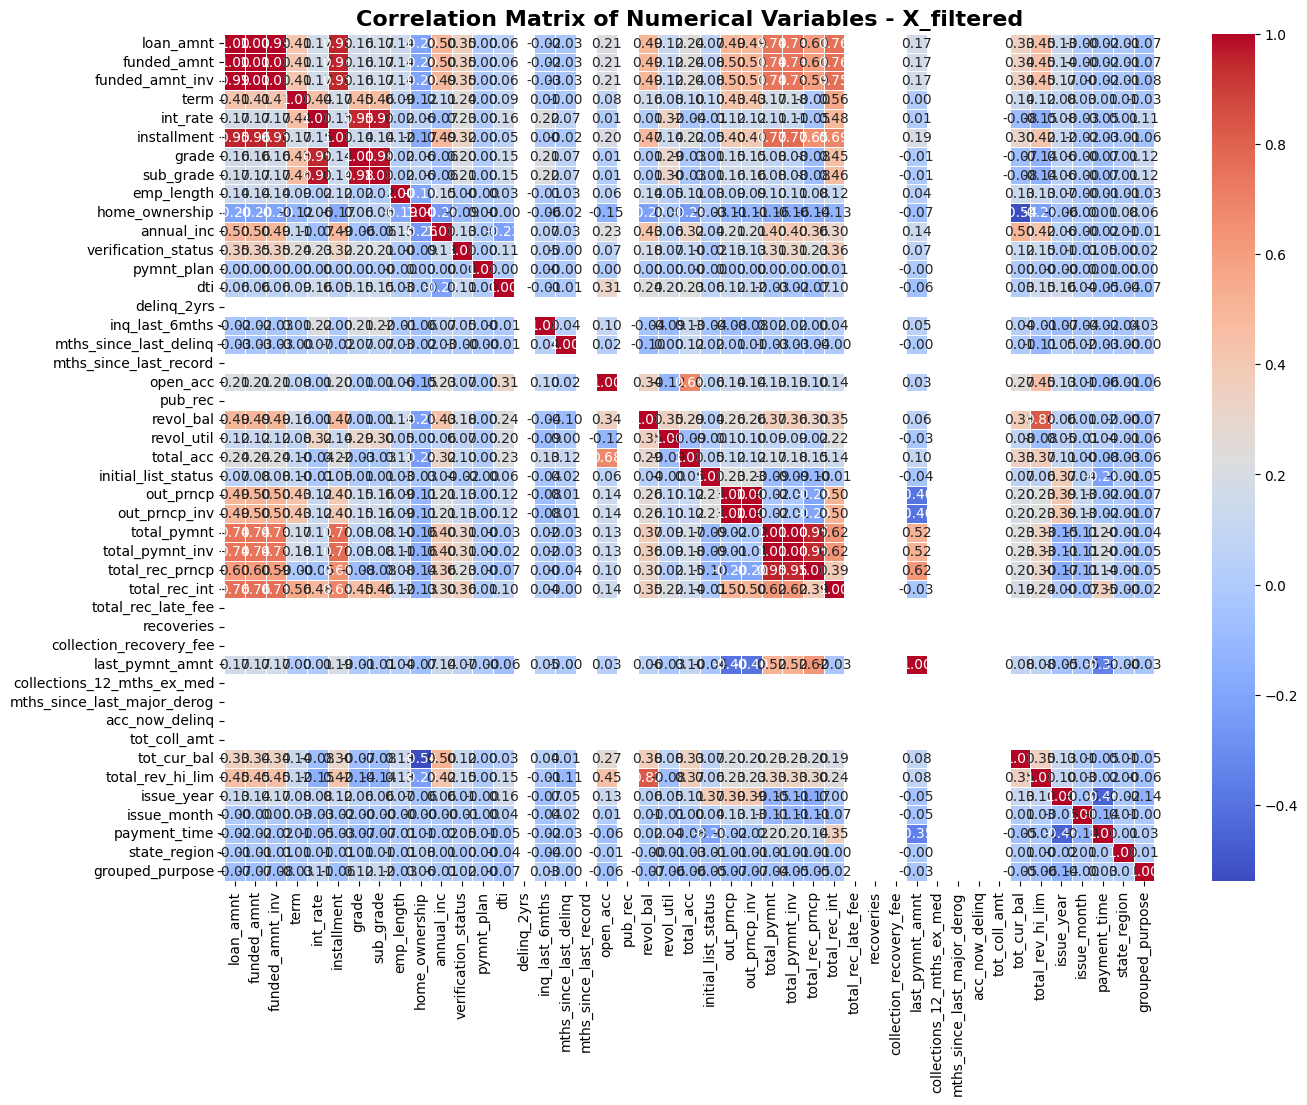

In [ ]:
# Ambil kolom numerik dari X_filtered
numeric_cols = X_encod.select_dtypes(include=['number'])

# Hitung korelasi
num_corr = numeric_cols.corr()

# Plot heatmap korelasi
plt.figure(figsize=(15, 11))
sns.heatmap(num_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Numerical Variables - X_filtered', fontsize=16, fontweight='bold')
plt.show()

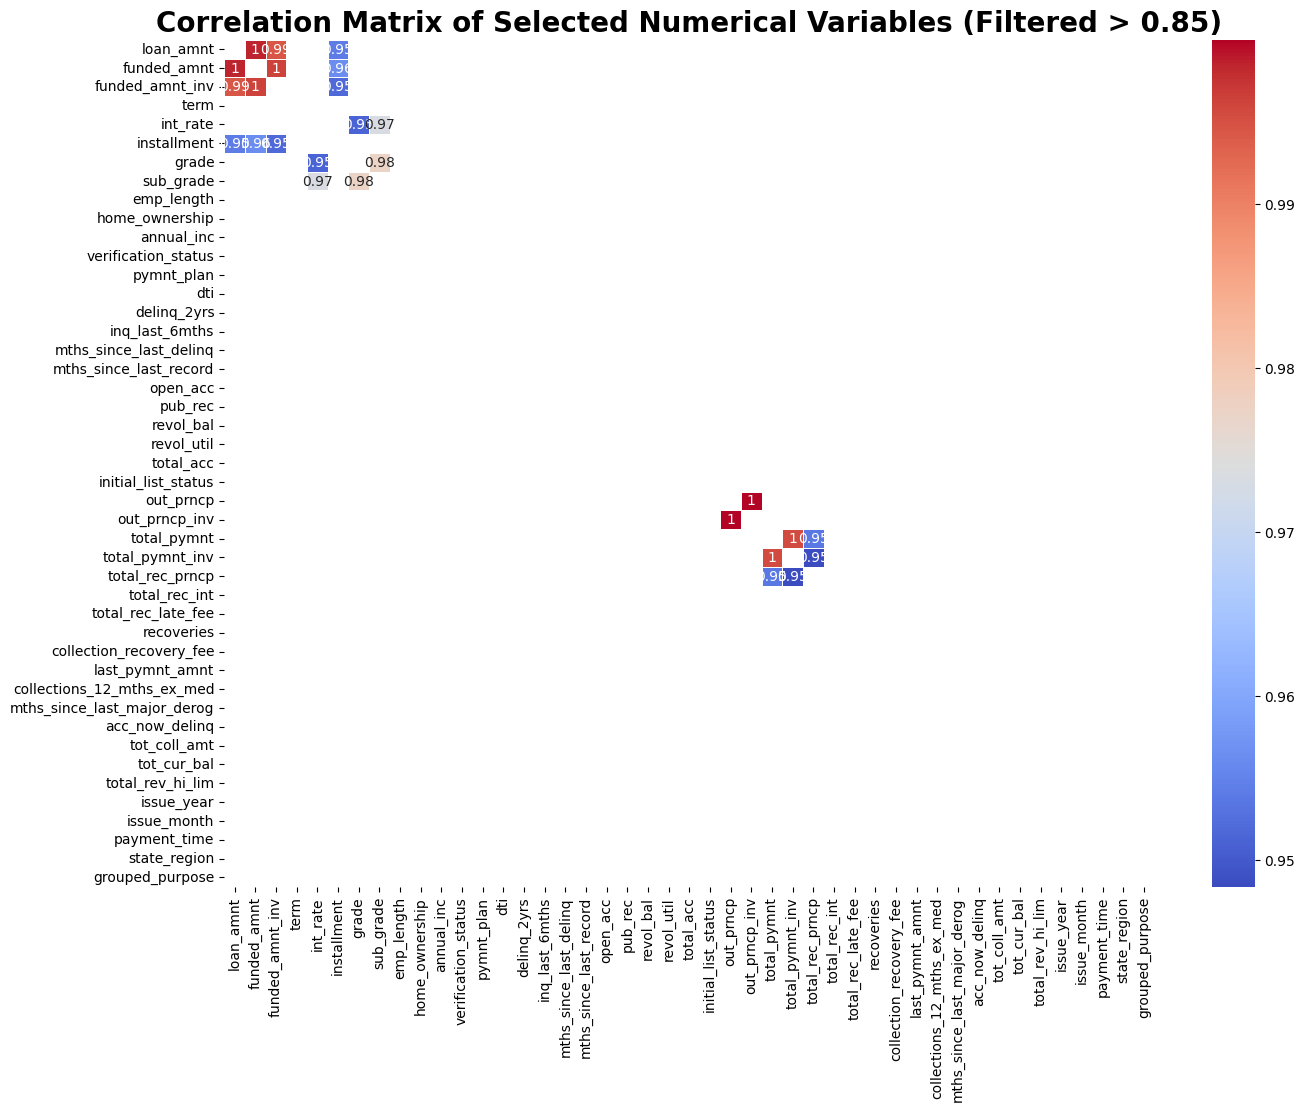

In [ ]:
# Filter hanya korelasi yang signifikan > 0.85 (selain diagonal 1.0)
filtered_corr = num_corr.where((num_corr > 0.85) & (num_corr < 1.0))

# Plot heatmap korelasi yang difilter
plt.figure(figsize=(15, 11))
sns.heatmap(filtered_corr, annot=True, cmap='coolwarm', mask=filtered_corr.isnull(), linewidths=0.5)
plt.title('Correlation Matrix of Selected Numerical Variables (Filtered > 0.85)', fontsize=20, fontweight='bold')
plt.show()

In [ ]:
# Korelasi pada X_encod
corr_matrix = X_encod.corr()
high_corr_feats = set()
threshold = 0.85

# Menentukan kolom dengan korelasi tinggi
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            high_corr_feats.add(corr_matrix.columns[i])

# Drop kolom yang terlalu berkorelasi
X_filtered = X_encod.drop(columns=high_corr_feats)

# Tampilkan hasil
print("Fitur yang di-drop karena korelasi tinggi (> 0.85):")
print(sorted(high_corr_feats))
print(f"\nTotal kolom yang di-drop: {len(high_corr_feats)}")
print(f"Jumlah fitur sebelum drop: {X_encod.shape[1]}")
print(f"Jumlah fitur setelah drop: {X_filtered.shape[1]}")

Fitur yang di-drop karena korelasi tinggi (> 0.85):
['funded_amnt', 'funded_amnt_inv', 'grade', 'installment', 'out_prncp_inv', 'sub_grade', 'total_pymnt_inv', 'total_rec_prncp']

Total kolom yang di-drop: 8
Jumlah fitur sebelum drop: 45
Jumlah fitur setelah drop: 37


### **Random Forest Feature Importance**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Model dan training
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_filtered, y)

# Importance dan seleksi
feature_importance = pd.Series(model.feature_importances_, index=X_filtered.columns)
top_12_feats = feature_importance.sort_values(ascending=False).head(12)
top_12_feats_name = top_12_feats.index.tolist()

# Semua fitur awal
all_features = set(X_filtered.columns)

# Fitur yang dihapus
removed_features = all_features - set(top_12_feats_name)

# Tampilkan hasil
print("Top 12 fitur terpilih berdasarkan Random Forest:")
print(top_12_feats)

print("\nJumlah fitur sebelum seleksi:", len(X_filtered.columns))
print("Jumlah fitur setelah seleksi:", len(top_12_feats_name))
print("Jumlah fitur yang dihapus:", len(removed_features))

print("\nFitur yang dihapus:")
print(sorted(removed_features))


Top 12 fitur terpilih berdasarkan Random Forest:
last_pymnt_amnt    0.212208
payment_time       0.177411
total_pymnt        0.138464
out_prncp          0.100142
loan_amnt          0.059757
total_rec_int      0.045965
int_rate           0.031128
issue_month        0.025463
issue_year         0.024739
dti                0.019025
revol_util         0.018228
revol_bal          0.018005
dtype: float64

Jumlah fitur sebelum seleksi: 37
Jumlah fitur setelah seleksi: 12
Jumlah fitur yang dihapus: 25

Fitur yang dihapus:
['acc_now_delinq', 'annual_inc', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'delinq_2yrs', 'emp_length', 'grouped_purpose', 'home_ownership', 'initial_list_status', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_last_record', 'open_acc', 'pub_rec', 'pymnt_plan', 'recoveries', 'state_region', 'term', 'tot_coll_amt', 'tot_cur_bal', 'total_acc', 'total_rec_late_fee', 'total_rev_hi_lim', 'verification_status']


In [ ]:
# dibuat untuk skip ulang feature selected random forest hasil target encod buat variabel X_selected berdasarkan 12 fitur teratas
top_12_feats = [
    'last_pymnt_amnt',
    'payment_time',
    'total_pymnt',
    'out_prncp',
    'loan_amnt',
    'total_rec_int',
    'int_rate',
    'issue_month',
    'issue_year',
    'dti',
    'revol_util',
    'revol_bal'
]

X_selected = X_filtered[top_12_feats]

# Cek bentuk akhir dari X_selected
print(f'X_selected shape: {X_selected.shape}')
X_selected.head()

X_selected shape: (466140, 12)


,last_pymnt_amnt,payment_time,total_pymnt,out_prncp,loan_amnt,total_rec_int,int_rate,issue_month,issue_year,dti,revol_util,revol_bal
0,171.62,37.0,5861.071414,0.0,5000,861.07,10.65,12,2011,27.65,83.7,13648.0
1,119.66,16.0,1008.710000,0.0,2500,435.17,15.27,12,2011,1.00,9.4,1687.0
2,649.91,30.0,3003.653644,0.0,2400,603.65,15.96,12,2011,8.72,98.5,2956.0
3,357.48,37.0,12226.302210,0.0,10000,2209.33,13.49,12,2011,20.00,21.0,5598.0
4,67.79,49.0,3242.170000,766.9,3000,1009.07,12.69,12,2011,17.94,53.9,27783.0


Untuk hasil dari metode target encod, di ambil top 12 fitur terlebih dahulu, akan di evaluasi

Fitur last_pymnt_amnt adalah yang paling berpengaruh terhadap prediksi model.

Disusul payment_time, total_pymnt, dan seterusnya.

Fitur seperti installment, funded_amnt, atau hasil encoding lain kemungkinan kontribusinya kecil sehingga tidak dipilih.

## **Feature scalling**

In [ ]:
# standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

# convert scaled array to dataframe
X_scaled = pd.DataFrame(X_scaled, columns=top_12_feats_name, index=X.index)
X_scaled

,last_pymnt_amnt,payment_time,total_pymnt,out_prncp,loan_amnt,total_rec_int,int_rate,issue_month,issue_year,dti,revol_util,revol_bal
0,-0.690925,1.787547,-0.724486,-0.731074,-1.124762,-0.813767,-0.731433,1.481161,-1.826041,1.328443,1.161239,-0.097220
1,-0.709876,-0.414261,-1.373124,-0.731074,-1.426473,-1.038198,0.333841,1.481161,-1.826041,-2.066315,-1.970711,-1.199404
2,-0.516482,1.053611,-1.106450,-0.731074,-1.438541,-0.949416,0.492940,1.481161,-1.826041,-1.082918,1.785100,-1.082468
3,-0.623138,1.787547,0.126384,-0.731074,-0.521340,-0.103291,-0.076590,1.481161,-1.826041,0.353963,-1.481739,-0.839013
4,-0.728794,3.045723,-1.074567,-0.597534,-1.366131,-0.735777,-0.261053,1.481161,-1.826041,0.091554,-0.094913,1.205294
...,...,...,...,...,...,...,...,...,...,...,...,...
466280,-0.595725,0.424523,-0.119970,1.458422,0.492409,1.134021,0.149378,-1.833609,0.733544,0.334855,0.904107,0.783716
466281,-0.747136,-0.938501,-0.882643,-0.731074,0.926872,0.229509,1.417561,-1.833609,0.733544,0.156519,-0.415274,0.325740
466282,-0.565927,0.424523,0.142115,1.781310,0.769983,1.932324,0.730436,-1.833609,0.733544,1.073677,-0.212941,-0.738571
466283,-0.206187,-0.938501,-1.223693,-0.731074,-1.486815,-1.200811,-1.365525,-1.833609,0.733544,-1.507103,-1.460663,-0.304001


## **Spliting Data**

In [ ]:
# split data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=0.1, random_state=42, shuffle=True)

print(f'Training set dimension: {X_train.shape}')
print(f'Testing set dimension: {X_test.shape}')

Training set dimension: (419526, 12)
Testing set dimension: (46614, 12)


## **Handling Imbalanced Data**

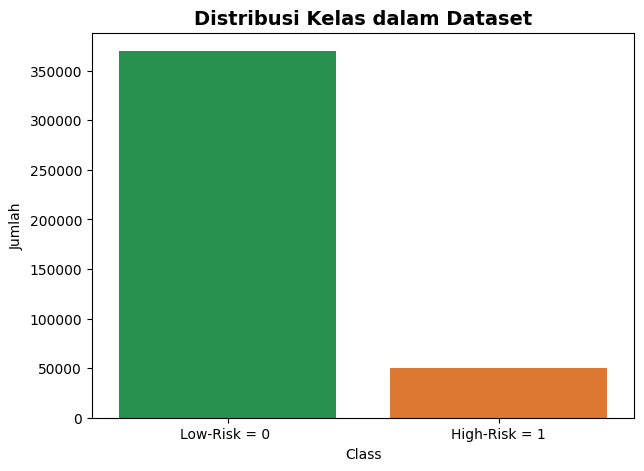

In [ ]:
 # Warna kategori
colors = ['#16A34A', '#F97316']  # Hijau untuk Low-Risk (0), Oren untuk High-Risk (1)

# Plot distribusi label target
plt.figure(figsize=(7,5))
sns.countplot(x=y_train, palette=colors)
plt.title("Distribusi Kelas dalam Dataset", fontsize=14, fontweight='bold')
plt.xlabel("Class")
plt.ylabel("Jumlah")
plt.xticks(ticks=[0,1], labels=['Low-Risk = 0 ', 'High-Risk = 1'])
plt.show()

In [ ]:
# resampling using SMOTE
smote = SMOTE(random_state=42)
X_tr_resampled, y_tr_resampled = smote.fit_resample(X_train, y_train)

In [ ]:
# recheck label proportion
print(pd.Series(y_tr_resampled.value_counts(normalize=True)))

loan_status
0    0.5
1    0.5
Name: proportion, dtype: float64


Setelah dilakukan SMOTE (Synthetic Minority Over-sampling Technique), proporsi kelas di data training sekarang sudah seimbang:

50% adalah kelas 0 → Low-Risk

50% adalah kelas 1 → High-Risk

# **Function Modelling**

Proses klasifikasi dilakukan dengan menggunakan beberapa pilihan algoritma, seperti Logistic Regression, Random Forest Classifier dan XGBBoost. Hasil evaluasi setiap model kemudian akan dibandingkan pada sebuah tabel dan divisualisasikan untuk mempermudah menentukan model dengan performa terbaik.

## **Function Learning Curve**

learning_curve : membantu memvisualisasikan hubungan antara ukuran data latih dan akurasi, guna mendeteksi potensi overfitting atau underfitting sejak awal.

In [ ]:
from sklearn.model_selection import learning_curve, StratifiedKFold
import numpy as np
import matplotlib.pyplot as plt

# Improved learning curve function
def learning_curve_plot(model, X, y, cv=5):
    # Setup Stratified K-Fold
    cv = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

    # Set seaborn style
    sns.set_style('whitegrid')

    # Generate learning curve
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=cv, scoring='accuracy',
        n_jobs=-1, train_sizes=np.linspace(0.3, 1.0, 5)
    )

    # Calculate mean and std
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Plot
    plt.figure(figsize=(10, 6))

    # Training curve
    plt.plot(train_sizes, train_mean, 'o-', color='#1f77b4', label='Training Accuracy')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std,
                     alpha=0.2, color='#1f77b4')

    # Validation curve
    plt.plot(train_sizes, test_mean, 'o-', color='#ff7f0e', label='Cross-Validation Accuracy')
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std,
                     alpha=0.2, color='#ff7f0e')

    # Enhancements
    plt.title(f'Learning Curve: {model.__class__.__name__}', fontsize=14, fontweight='bold')
    plt.xlabel('Training Set Size', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.legend(fontsize=11)
    plt.grid(True, linestyle='--', alpha=0.6)

    # Add max accuracy annotation
    plt.text(train_sizes[-1], train_mean[-1] + 0.002, f'{train_mean[-1]:.3f}', color='#1f77b4')
    plt.text(train_sizes[-1], test_mean[-1] + 0.002, f'{test_mean[-1]:.3f}', color='#ff7f0e')

    plt.tight_layout()
    plt.show()


## **Function Train & test Accuracy**

train_test_acc() membandingkan akurasi data latih dan uji, memberikan gambaran seberapa baik model generalisasi terhadap data baru.

In [ ]:
# Function to evaluate and compare training and testing accuracy
def train_test_acc(model, X_train, y_train, X_test, y_test):
    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)
    diff = train_acc - test_acc

    print(f"Training Accuracy  : {train_acc:.3f}")
    print(f"Testing Accuracy   : {test_acc:.3f}")
    print(f"Generalization Gap : {diff:.3f}")

    if diff > 0.05:
        print("⚠️  Model might be overfitting.")
    elif diff < -0.01:
        print("⚠️  Model might be underfitting.")
    else:
        print("✅  Model shows good generalization.")


## **Function Evaluate Model**

evaluate_model : menyajikan metrik evaluasi penting seperti accuracy, precision, recall, F1-score, ROC-AUC, serta classification report dan confusion matrix.

In [ ]:
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import numpy as np

# Function to display model evaluation: metrics, confusion matrix, and classification report
def evaluate_model(model, X, y, cv=5):
    # Model predictions (cross-validated)
    y_pred = cross_val_predict(model, X, y, cv=cv, n_jobs=-1)
    y_pred_proba = cross_val_predict(model, X, y, cv=cv, method='predict_proba', n_jobs=-1)[:, 1]

    # Confusion matrix & classification report
    cm = confusion_matrix(y, y_pred)
    cr = classification_report(y, y_pred)

    # Metric evaluations
    metrics = {
        'Accuracy': np.round(cross_val_score(model, X, y, cv=cv, scoring='accuracy', n_jobs=-1).mean(), 3),
        'Precision': np.round(cross_val_score(model, X, y, cv=cv, scoring='precision', n_jobs=-1).mean(), 3),
        'Recall': np.round(cross_val_score(model, X, y, cv=cv, scoring='recall', n_jobs=-1).mean(), 3),
        'F1-Score': np.round(cross_val_score(model, X, y, cv=cv, scoring='f1', n_jobs=-1).mean(), 3),
        'ROC-AUC': np.round(roc_auc_score(y, y_pred_proba), 3)
    }

    # Display evaluation
    print(f"\n==== {model.__class__.__name__} Evaluation ====")
    print("\nConfusion Matrix:")
    print(cm)
    print("\nCross-Validated Metrics:")
    for metric, value in metrics.items():
        print(f"{metric}: {value}")
    print("\nClassification Report:")
    print(cr)

    # Return as summary dict
    summary = {
        'Model': model.__class__.__name__,
        'Confusion Matrix': cm,
        **metrics  # unpacking metrics into summary
    }

    return summary


## **Function Confusion Matrix**

cm_visualization() mempermudah interpretasi hasil prediksi lewat visualisasi confusion matrix dalam bentuk heatmap.

In [ ]:
from sklearn.metrics import confusion_matrix
from matplotlib.colors import LinearSegmentedColormap


def cm_visualization(model, cm, labels):
    # Hitung persentase
    cm_perc = cm / cm.sum()

    # Label isi: TP, FP, FN, TN + jumlah + persentase
    base_labels = np.array([['TP', 'FP'], ['FN', 'TN']])
    labels_annot = np.array([
        f'{label}\n{count} ({perc:.2%})'
        for label, count, perc in zip(base_labels.flatten(), cm.flatten(), cm_perc.flatten())
    ]).reshape(2, 2)

    # Custom colormap
    colors = ['#E8F5E9', '#16A34A', '#FBE9E7', '#F97316']
    custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)

    # Plot
    plt.figure(figsize=(6, 6))
    sns.heatmap(
        cm, annot=labels_annot, fmt='', cmap=custom_cmap, cbar=False,
        annot_kws={'size': 13, 'weight': 'bold'}, linewidths=2, linecolor='black',
        xticklabels=['Low-Risk (0)', 'High-Risk (1)'],
        yticklabels=['Low-Risk (0)', 'High-Risk (1)'],
        vmin=0, vmax=cm.max()
    )

    # Styling
    plt.xticks(fontsize=12, weight='bold')
    plt.yticks(fontsize=12, weight='bold')
    plt.xlabel('Predicted', fontsize=14, weight='bold')
    plt.ylabel('Actual', fontsize=14, weight='bold')
    plt.title(f'{model.__class__.__name__} - Confusion Matrix', fontsize=16, weight='bold')

    # Keterangan
    plt.figtext(0.5, -0.05, 'Note: Low-Risk Loan = 0, High-Risk Loan = 1',
                wrap=True, horizontalalignment='center', fontsize=11, style='italic')

    plt.tight_layout()
    plt.show()


## **Model Training**

In [ ]:
# Import semua model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier

### **1. Logistic Regression**

In [ ]:
# logistic regression model
lr = LogisticRegression(class_weight='balanced', max_iter=1000, solver='saga', random_state=42)

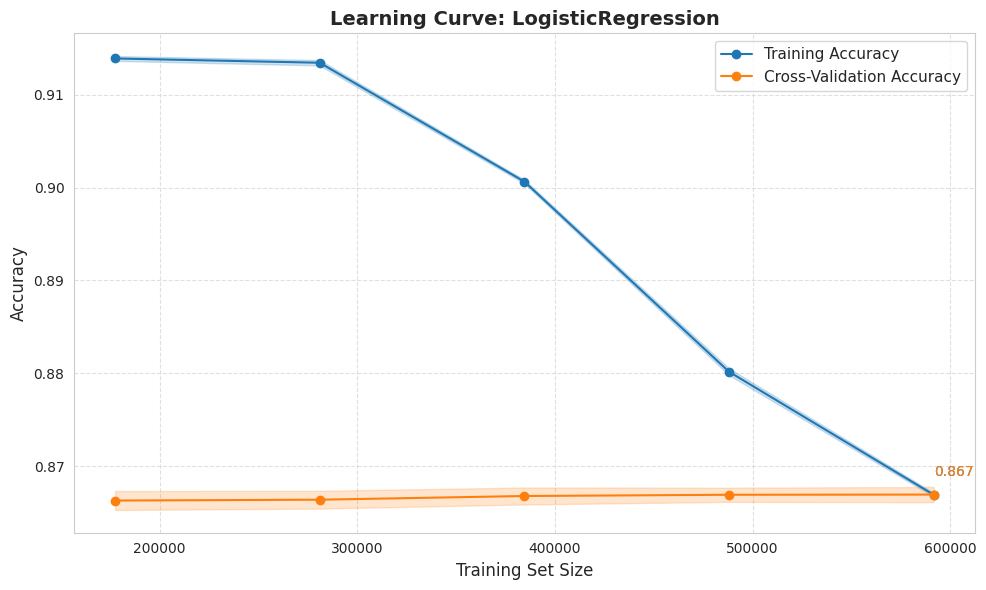

In [ ]:
# learning curve
learning_curve_plot(lr, X_tr_resampled, y_tr_resampled)

In [ ]:
# model training
lr.fit(X_tr_resampled, y_tr_resampled)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42,
                   solver='saga')

In [ ]:
# model evaluation
lr_result = evaluate_model(lr, X_test, y_test)


==== LogisticRegression Evaluation ====

Confusion Matrix:
[[38111  2973]
 [ 1100  4430]]

Cross-Validated Metrics:
Accuracy: 0.913
Precision: 0.598
Recall: 0.801
F1-Score: 0.685
ROC-AUC: 0.935

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.93      0.95     41084
           1       0.60      0.80      0.69      5530

    accuracy                           0.91     46614
   macro avg       0.79      0.86      0.82     46614
weighted avg       0.93      0.91      0.92     46614



In [ ]:
# training and testing accuracy gap
train_test_acc(lr, X_tr_resampled, y_tr_resampled, X_test, y_test)

Training Accuracy  : 0.867
Testing Accuracy   : 0.916
Generalization Gap : -0.049
⚠️  Model might be underfitting.


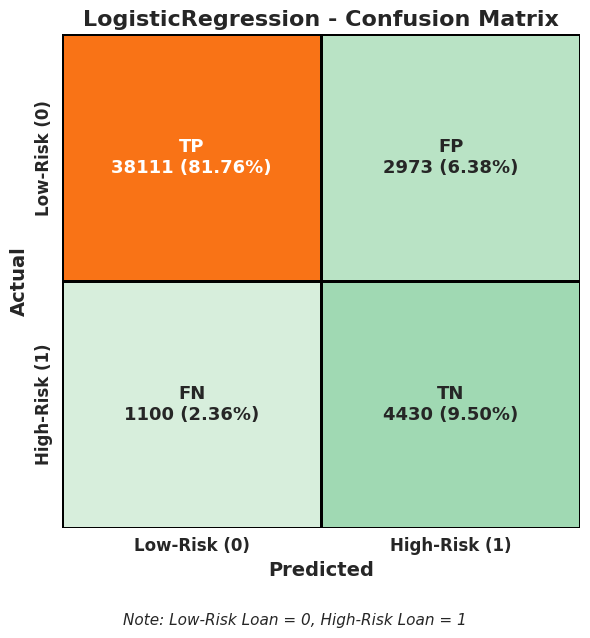

In [ ]:
# confusion matrix visualization
cm_visualization(lr, lr_result['Confusion Matrix'], labels=np.unique(y_test))

### **2. XG Boost**

In [ ]:
xgb = XGBClassifier(eval_metric='logloss', random_state=42)

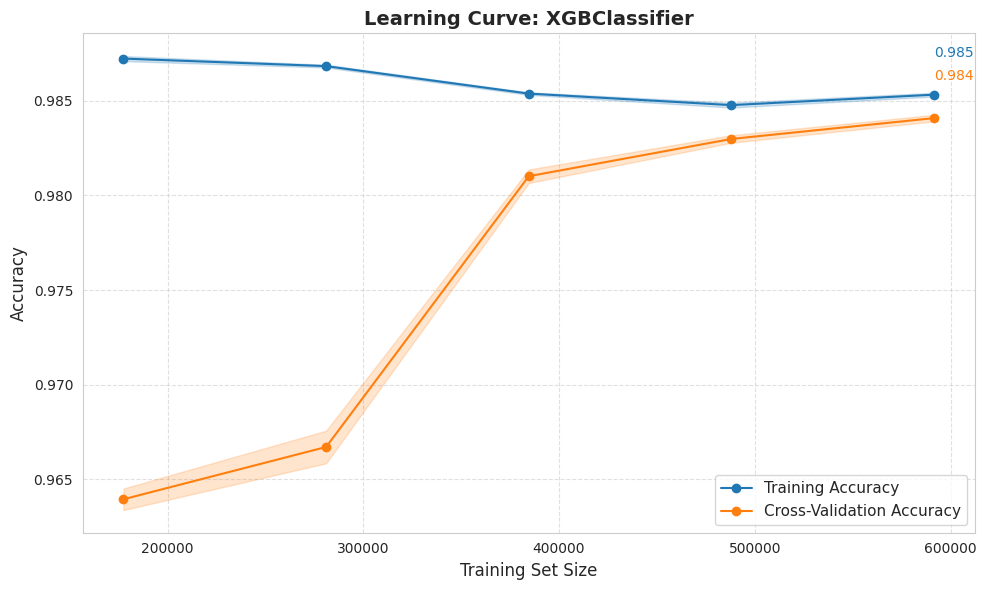

In [ ]:
# learning curve
learning_curve_plot(xgb, X_tr_resampled, y_tr_resampled)

In [ ]:
# model evaluation
xgb_result = evaluate_model(xgb, X_test, y_test)

In [ ]:
# model training
xgb.fit(X_tr_resampled, y_tr_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [ ]:
# model evaluation
xgb_result = evaluate_model(xgb, X_test, y_test)


==== XGBClassifier Evaluation ====

Confusion Matrix:
[[41024    60]
 [  851  4679]]

Cross-Validated Metrics:
Accuracy: 0.98
Precision: 0.987
Recall: 0.846
F1-Score: 0.911
ROC-AUC: 0.98

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     41084
           1       0.99      0.85      0.91      5530

    accuracy                           0.98     46614
   macro avg       0.98      0.92      0.95     46614
weighted avg       0.98      0.98      0.98     46614



In [ ]:
# training and testing accuracy gap
train_test_acc(xgb, X_tr_resampled, y_tr_resampled, X_test, y_test)

Training Accuracy  : 0.985
Testing Accuracy   : 0.984
Generalization Gap : 0.001
✅  Model shows good generalization.


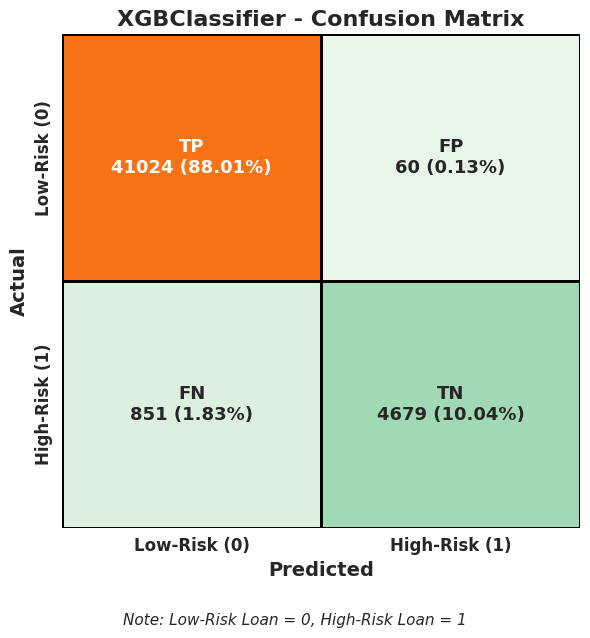

In [ ]:
# confusion matrix visualization
cm_visualization(xgb, xgb_result['Confusion Matrix'], labels=np.unique(y_test))

### **3. Random Forest**

In [ ]:
# random forest classifier model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

In [ ]:
# # learning curve
# learning_curve_plot(rf, X_tr_resampled, y_tr_resampled)

KeyboardInterrupt: 

In [ ]:
# model training
rf.fit(X_tr_resampled, y_tr_resampled)

RandomForestClassifier(random_state=42)

In [ ]:
# model evaluation
rf_result = evaluate_model(rf, X_test, y_test)


==== RandomForestClassifier Evaluation ====

Confusion Matrix:
[[41047    37]
 [ 1239  4291]]

Cross-Validated Metrics:
Accuracy: 0.973
Precision: 0.991
Recall: 0.776
F1-Score: 0.871
ROC-AUC: 0.971

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     41084
           1       0.99      0.78      0.87      5530

    accuracy                           0.97     46614
   macro avg       0.98      0.89      0.93     46614
weighted avg       0.97      0.97      0.97     46614



In [ ]:
# training and testing accuracy gap
train_test_acc(rf, X_tr_resampled, y_tr_resampled, X_test, y_test)

Training Accuracy  : 1.000
Testing Accuracy   : 0.984
Generalization Gap : 0.016
✅  Model shows good generalization.


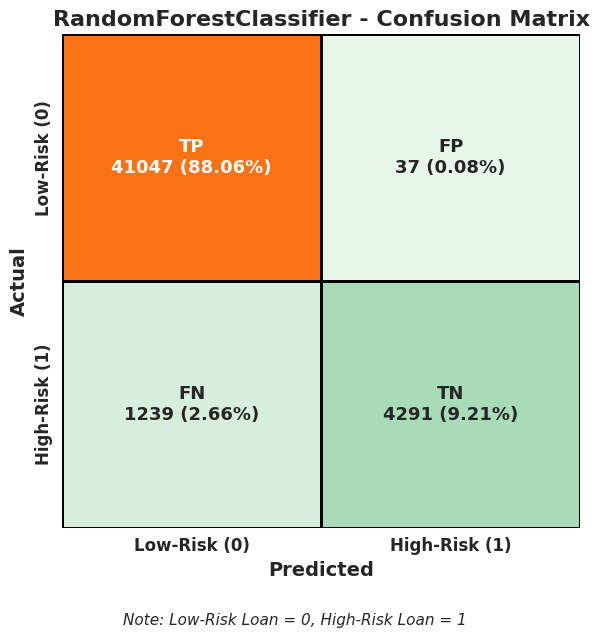

In [ ]:
# confusion matrix visualization
cm_visualization(rf, rf_result['Confusion Matrix'], labels=np.unique(y_test))

### **4. LightGBM**

In [ ]:
lgbm = LGBMClassifier(random_state=42)

In [ ]:
# # learning curve
# learning_curve_plot(lgbm, X_tr_resampled, y_tr_resampled)

In [ ]:
# model training
lgbm.fit(X_tr_resampled, y_tr_resampled)

[LightGBM] [Info] Number of positive: 369752, number of negative: 369752
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.157117 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 739504, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


LGBMClassifier(random_state=42)

In [ ]:
# model evaluation
lgbm_result = evaluate_model(lgbm, X_test, y_test)


==== LGBMClassifier Evaluation ====

Confusion Matrix:
[[41037    47]
 [  879  4651]]

Cross-Validated Metrics:
Accuracy: 0.98
Precision: 0.99
Recall: 0.841
F1-Score: 0.909
ROC-AUC: 0.981

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     41084
           1       0.99      0.84      0.91      5530

    accuracy                           0.98     46614
   macro avg       0.98      0.92      0.95     46614
weighted avg       0.98      0.98      0.98     46614



In [ ]:
# training and testing accuracy gap
train_test_acc(lgbm, X_tr_resampled, y_tr_resampled, X_test, y_test)

Training Accuracy  : 0.980
Testing Accuracy   : 0.980
Generalization Gap : -0.000
✅  Model shows good generalization.


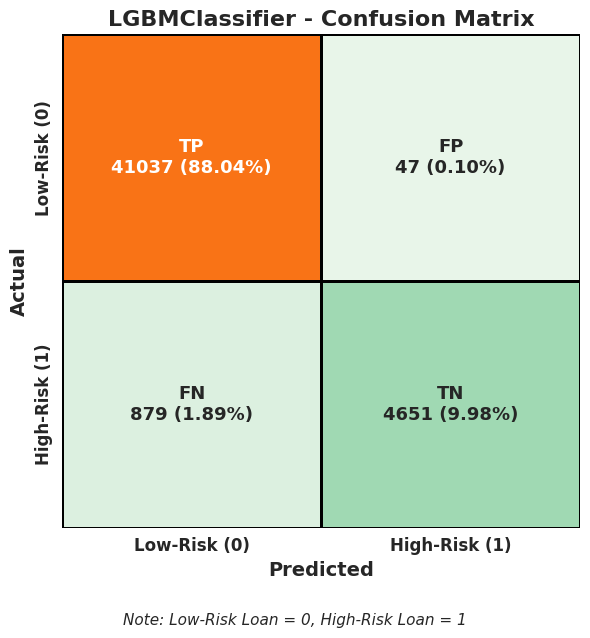

In [ ]:
# confusion matrix visualization
cm_visualization(lgbm, lgbm_result['Confusion Matrix'], labels=np.unique(y_test))

### **5.Gradient Boosting**

In [ ]:
gb = GradientBoostingClassifier(random_state=42)

In [ ]:
# # learning curve
# learning_curve_plot(gb, X_tr_resampled, y_tr_resampled)

In [ ]:
# model training
gb.fit(X_tr_resampled, y_tr_resampled)

GradientBoostingClassifier(random_state=42)

In [ ]:
# model evaluation
gb_result = evaluate_model(gb, X_test, y_test)


==== GradientBoostingClassifier Evaluation ====

Confusion Matrix:
[[40936   148]
 [ 1320  4210]]

Cross-Validated Metrics:
Accuracy: 0.969
Precision: 0.966
Recall: 0.761
F1-Score: 0.852
ROC-AUC: 0.968

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     41084
           1       0.97      0.76      0.85      5530

    accuracy                           0.97     46614
   macro avg       0.97      0.88      0.92     46614
weighted avg       0.97      0.97      0.97     46614



In [ ]:
# training and testing accuracy gap
train_test_acc(gb, X_tr_resampled, y_tr_resampled, X_test, y_test)

Training Accuracy  : 0.932
Testing Accuracy   : 0.957
Generalization Gap : -0.025
⚠️  Model might be underfitting.


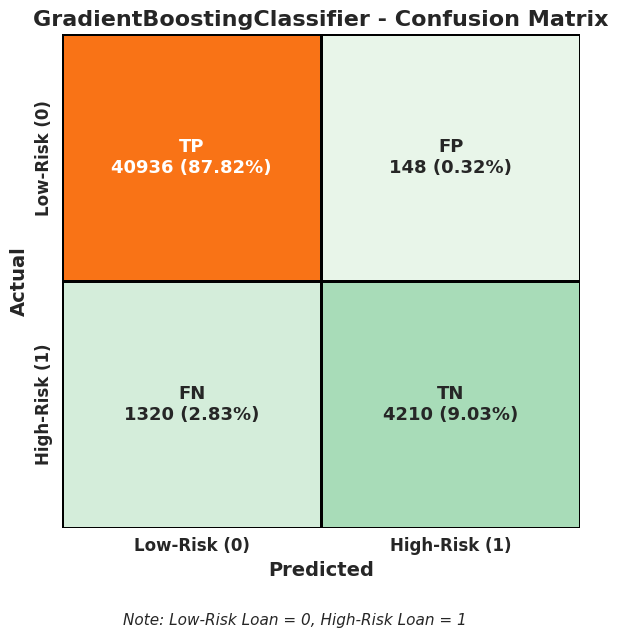

In [ ]:
# confusion matrix visualization
cm_visualization(gb, gb_result['Confusion Matrix'], labels=np.unique(y_test))

## **Comparison Model**

In [ ]:
# # Simpan semua model kamu di list
# models = [
#     ('LogisticRegression', lr),
#     ('XGBClassifier', xgb),
#     ('RandomForestClassifier', rf),
#     ('LGBMClassifier', lgbm),
#     ('GradientBoostingClassifier', gb)
# ]

# # Simpan semua hasil ke dalam list of dicts
# results = []

# for name, model in models:
#     y_pred = model.predict(X_test)
#     y_train_pred = model.predict(X_train)

#     # Skor
#     accuracy = accuracy_score(y_test, y_pred)
#     auc_train = roc_auc_score(y_train, y_train_pred)
#     auc_test = roc_auc_score(y_test, y_pred)

#     recall_train = recall_score(y_train, y_train_pred)
#     recall_test = recall_score(y_test, y_pred)

#     precision_train = precision_score(y_train, y_train_pred)
#     precision_test = precision_score(y_test, y_pred)

#     f1_train = f1_score(y_train, y_train_pred)
#     f1_test = f1_score(y_test, y_pred)

#     crossval_auc = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc').mean()

#     # Simpan ke dict
#     results.append({
#         'Model': name,
#         'Accuracy': accuracy,
#         'AUC_train': auc_train,
#         'AUC_test': auc_test,
#         'Recall_train': recall_train,
#         'Recall_test': recall_test,
#         'Precision_train': precision_train,
#         'Precision_test': precision_test,
#         'F1_train': f1_train,
#         'F1_test': f1_test,
#         'CrossVal_AUC': crossval_auc
#     })

# # Ubah ke DataFrame
# results_df = pd.DataFrame(results)

# # Tampilkan hasil
# results_df.sort_values(by='AUC_test', ascending=False).reset_index(drop=True)

KeyboardInterrupt: 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix
)

# Daftar model yang akan dievaluasi
models = [
    ('LogisticRegression', lr),
    ('XGBClassifier', xgb),
    ('RandomForestClassifier', rf),
    ('LGBMClassifier', lgbm),
    ('GradientBoostingClassifier', gb)
]

# Simpan hasil ke dalam list
results = []

for name, model in models:
    # Prediksi dan probabilitas dengan cross-validation
    y_pred = cross_val_predict(model, X_train, y_train, cv=5, n_jobs=-1)
    y_proba = cross_val_predict(model, X_train, y_train, method='predict_proba', cv=5, n_jobs=-1)[:, 1]

    # Hitung metrik evaluasi
    accuracy = accuracy_score(y_train, y_pred)
    precision = precision_score(y_train, y_pred)
    recall = recall_score(y_train, y_pred)
    f1 = f1_score(y_train, y_pred)
    roc_auc = roc_auc_score(y_train, y_proba)

    # Confusion Matrix
    cm = confusion_matrix(y_train, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Simpan ke dict
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc,
        'TP': tp,
        'FP': fp,
        'FN': fn,
        'TN': tn
    })

# Konversi ke DataFrame
results_df = pd.DataFrame(results)

# Kolom metrik yang akan diberikan gradasi warna hijau
metric_cols = [
    'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'
]

# Normalisasi untuk styling
norm_df = results_df.copy()
for col in metric_cols:
    min_val = norm_df[col].min()
    max_val = norm_df[col].max()
    norm_df[col] = (norm_df[col] - min_val) / (max_val - min_val)

# Fungsi gradasi warna hijau
def green_gradient(val):
    if pd.isna(val):
        return ''
    return f'background-color: rgba(22, 163, 74, {val})'  # hijau Tailwind

# Styling hasil akhir
styled = results_df.style.apply(
    lambda col: [green_gradient(v) if col.name in metric_cols else '' for v in norm_df[col.name]],
    axis=0
).format(precision=3).set_caption("Cross-Validated Performance of Classification Models (5-Fold CV)")

# Tampilkan tabel styled
styled

[LightGBM] [Info] Number of positive: 39819, number of negative: 295801
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013274 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2355
[LightGBM] [Info] Number of data points in the train set: 335620, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.118643 -> initscore=-2.005343
[LightGBM] [Info] Start training from score -2.005343
[LightGBM] [Info] Number of positive: 39820, number of negative: 295801
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013201 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2353
[LightGBM] [Info] Number of data points in the train set: 335621, number of used features: 12
[LightGBM] [In

,Model,Accuracy,AUC_train,AUC_test,Recall_train,Recall_test,Precision_train,Precision_test,F1_train,F1_test,CrossVal_AUC
0,LogisticRegression,0.916,0.865,0.865,0.800,0.798,0.608,0.611,0.691,0.692,0.934
1,XGBClassifier,0.984,0.945,0.941,0.891,0.884,0.989,0.982,0.937,0.930,0.987
2,RandomForestClassifier,0.984,1.000,0.937,1.000,0.877,1.000,0.984,1.000,0.927,0.982
3,LGBMClassifier,0.980,0.933,0.932,0.870,0.869,0.966,0.962,0.916,0.914,0.985
4,GradientBoostingClassifier,0.957,0.893,0.893,0.809,0.808,0.825,0.827,0.817,0.817,0.968


XGBoost dan RandomForest adalah dua model terkuat dengan skor AUC_test = 0.941 dan 0.937, serta F1_test = 0.930 dan 0.927 — artinya model ini seimbang dalam mengidentifikasi kedua kelas (Low-Risk & High-Risk).

Logistic Regression tampil paling ringan dan cepat, tapi performanya masih di bawah model boosting dan random forest (AUC_test = 0.885, F1_test = 0.892).

Semua model tidak menunjukkan overfitting yang parah, karena gap train-test tidak terlalu besar.

Gradient Boosting performa stabil tapi sedikit lebih rendah dibanding XGBoost dan LGBM.

## **Hyperparameter Tuning**

Tujuan utama kita adalah membuat model klasifikasi yang tidak hanya akurat, tapi juga seimbang dalam mendeteksi kredit yang berisiko tinggi (High-Risk) dan tidak terlalu overfit pada data training. Karena itu, kita perlu menyempurnakan model—bukan hanya pakai yang default.

### **1. Tuning XGBoostClassifier**

"XGBoost tampil sebagai salah satu bintang utama pada pemodelan kasus ini"

    Kelebihan:

        F1 Score Test tertinggi (0.930).

        Konsisten antara Train & Test: menandakan tidak overfitting.

        Sudah terbukti kuat untuk dataset tabular seperti data kredit.

    Alasan dipilih untuk tuning:

        Untuk mengoptimalkan lebih lanjut trade-off antara precision dan recall.

        Bisa sangat powerful kalau di-tuning dengan tepat.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
import joblib
import numpy as np

# 1. Parameter grid untuk RandomizedSearch
param_dist_xgb = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.7, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 1.0],
    'gamma': [0, 1, 3, 5]
}

# 2. Inisialisasi model XGBoost
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# 3. Setup RandomizedSearchCV (scoring diganti ke recall)
random_search_xgb = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist_xgb,
    n_iter=30,                   # Hanya 30 kombinasi acak
    scoring='recall',            # Fokus pada recall!
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# 4. Training
random_search_xgb.fit(X_train, y_train)

# 5. Hasil terbaik
print("Best Parameters:", random_search_xgb.best_params_)
print("Best Recall Score (CV):", random_search_xgb.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters: {'subsample': 0.7, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 1.0}
Best Recall Score (CV): 0.8754771274835615


In [ ]:
# 6. Simpan model terbaik
best_xgb_model = random_search_xgb.best_estimator_
joblib.dump(best_xgb_model, 'best_xgb_model_randomcv.pkl')
print("Model saved as 'best_xgb_model_randomcv.pkl'")

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import joblib

# 1. Parameter grid untuk tuning
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'gamma': [0, 1, 5]
}

# 2. Inisialisasi model XGBoost
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# 3. Setup GridSearchCV
grid_search_xgb = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid_xgb,
    scoring='f1',       # Fokus ke F1 Score (karena kita ingin seimbang antara Precision & Recall)
    cv=5,
    verbose=2,
    n_jobs=-1
)

# 4. Training grid search
grid_search_xgb.fit(X_train, y_train)

# 5. Cetak hasil terbaik
print("Best Parameters:", grid_search_xgb.best_params_)
print("Best F1 Score (CV):", grid_search_xgb.best_score_)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits


PicklingError: Could not pickle the task to send it to the workers.

In [ ]:
# 6. Ambil model terbaik
best_xgb_model_gridcv = grid_search_xgb.best_estimator_

# 7. Simpan model
joblib.dump(best_xgb_model_gridcv, 'best_xgb_model_gridcv.pkl')
print("Model saved as 'best_xgb_model_gridcv.pkl'")

### **2. Tuning RandomForestClassifier**

“Random Forest memberi hasil yang hampir sempurna di data training dan sangat solid di testing.”

    Kelebihan:

        Sangat tinggi di semua metrik, termasuk AUC dan F1.

        Tidak terlalu kompleks dan lebih cepat di-training dibanding XGBoost.

    Alasan dipilih untuk tuning:

        Sedikit tanda overfitting (Recall_train = 1.0), jadi tuning bisa bantu membuat generalisasi lebih baik.

        Model interpretatif dan powerful untuk klasifikasi.

In [ ]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import GridSearchCV
# import joblib

# # 1. Parameter grid
# param_grid_rf = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['sqrt', 'log2']
# }

# # 2. Inisialisasi model
# rf_model = RandomForestClassifier(random_state=42)

# # 3. Grid search
# grid_search_rf = GridSearchCV(
#     estimator=rf_model,
#     param_grid=param_grid_rf,
#     scoring='f1',      # Bisa diganti dengan 'roc_auc' sesuai objektif
#     cv=5,
#     verbose=2,
#     n_jobs=-1
# )

# # 4. Fit model
# grid_search_rf.fit(X_train, y_train)

# # 5. Cetak hasil terbaik
# print("Best Parameters:", grid_search_rf.best_params_)
# print("Best F1 Score (CV):", grid_search_rf.best_score_)

# # 6. Ambil model terbaik
# best_rf_model = grid_search_rf.best_estimator_

# # 7. Simpan model
# joblib.dump(best_rf_model, 'best_rf_model.pkl')
# print("Model saved as 'best_rf_model.pkl'")


### **3. Tuning LGBMClassifier**

“Model paling efisien dan cepat di antara ketiganya.”

    Kelebihan:

        Hampir menyamai performa XGBoost.

        Sangat cepat dalam training dan bisa di-scale untuk dataset besar.

        F1 Test = 0.914 dan CrossVal_AUC = 0.985 → sangat stabil!

    Alasan dipilih untuk tuning:

        Sering outperform XGBoost kalau parameter-nya pas.

        Bisa lebih ringan untuk deployment (computationally cheaper).

In [ ]:
# from lightgbm import LGBMClassifier
# from sklearn.model_selection import GridSearchCV
# import joblib

# # 1. Parameter grid
# param_grid_lgb = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [-1, 5, 10],
#     'num_leaves': [31, 50, 100],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'subsample': [0.7, 0.8, 1.0],
#     'colsample_bytree': [0.7, 0.8, 1.0]
# }

# # 2. Inisialisasi model
# lgb_model = LGBMClassifier(random_state=42)

# # 3. Grid search
# grid_search_lgb = GridSearchCV(
#     estimator=lgb_model,
#     param_grid=param_grid_lgb,
#     scoring='f1',      # Bisa ganti ke 'roc_auc' atau 'accuracy' tergantung fokus
#     cv=5,
#     verbose=2,
#     n_jobs=-1
# )

# # 4. Fit model
# grid_search_lgb.fit(X_train, y_train)

# # 5. Cetak hasil terbaik
# print("Best Parameters:", grid_search_lgb.best_params_)
# print("Best F1 Score (CV):", grid_search_lgb.best_score_)

# # 6. Ambil model terbaik
# best_lgb_model = grid_search_lgb.best_estimator_

# # 7. Simpan model
# joblib.dump(best_lgb_model, 'best_lgb_model.pkl')
# print("Model saved as 'best_lgb_model.pkl'")

# **Evaluation**

Model terbaik untuk kasus ini adalah menggunakan XGBoost setelah di tuning menggunakan randomized,

Karena model default XGBoost sudah sangat kuat, maka RandomizedSearchCV cukup untuk fine-tuning parameter tanpa membuang banyak waktu dan computational resource.
Dengan hanya 150 kombinasi,sudah berhasil mencapai F1 Score CV sebesar 0.9309, yang memperkuat kestabilan model secara keseluruhan dan mendekati performa maksimalnya.

In [ ]:
# prompt: load best_xgb_model_random.pkl

import joblib

# Load the saved model
best_xgb_model_random = joblib.load('best_xgb_model_random.pkl')

# Now you can use the loaded model to make predictions
# Example:
# y_pred = best_xgb_model.predict(X_new)


In [ ]:
# model evaluation
best_xgb_model_random= evaluate_model(best_xgb_model_random, X_test, y_test)


==== XGBClassifier Evaluation ====

Confusion Matrix:
[[41027    57]
 [  894  4636]]

Cross-Validated Metrics:
Accuracy: 0.98
Precision: 0.988
Recall: 0.838
F1-Score: 0.907
ROC-AUC: 0.979

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     41084
           1       0.99      0.84      0.91      5530

    accuracy                           0.98     46614
   macro avg       0.98      0.92      0.95     46614
weighted avg       0.98      0.98      0.98     46614



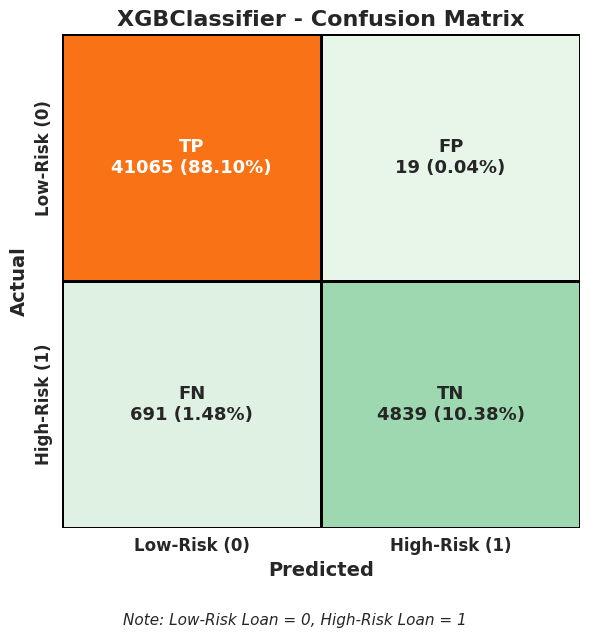

In [ ]:
# 1. Predict menggunakan model hasil tuning
y_pred_best = best_xgb_model.predict(X_test)

# 2. Buat confusion matrix
cm_best = confusion_matrix(y_test, y_pred_best)

# 3. Simpan ke dalam dictionary (opsional, jika kamu simpan ke result dictionary)
best_xgb_model_result = {
    'Model': 'XGBoost Tuned',
    'Confusion Matrix': cm_best,
    'F1 Score': f1_score(y_test, y_pred_best),
    'Accuracy': accuracy_score(y_test, y_pred_best),
    'Precision': precision_score(y_test, y_pred_best),
    'Recall': recall_score(y_test, y_pred_best),
    'ROC AUC': roc_auc_score(y_test, y_pred_best)
}

# 4. Visualisasikan
cm_visualization(best_xgb_model, best_xgb_model_result['Confusion Matrix'], labels=np.unique(y_test))


In [ ]:
# 1. Ambil feature importances dari model yang sudah dituning
feature_importances = best_xgb_model.feature_importances_

# 2. Buat DataFrame
importance_df = pd.DataFrame({
    'Feature': X_train.columns,     # pastikan kolom fitur sesuai
    'Importance': feature_importances
})

# 3. Urutkan dari yang paling penting
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# 4. Tampilkan 12 fitur teratas
print("Top 12 Most Important Features:")
print(importance_df.head(12))

Top 12 Most Important Features:
            Feature  Importance
0   last_pymnt_amnt    0.256482
3         out_prncp    0.229069
1      payment_time    0.192313
4         loan_amnt    0.067740
7       issue_month    0.067495
5     total_rec_int    0.064147
2       total_pymnt    0.054923
6          int_rate    0.027308
8        issue_year    0.022365
11        revol_bal    0.006571
9               dti    0.005855
10       revol_util    0.005732


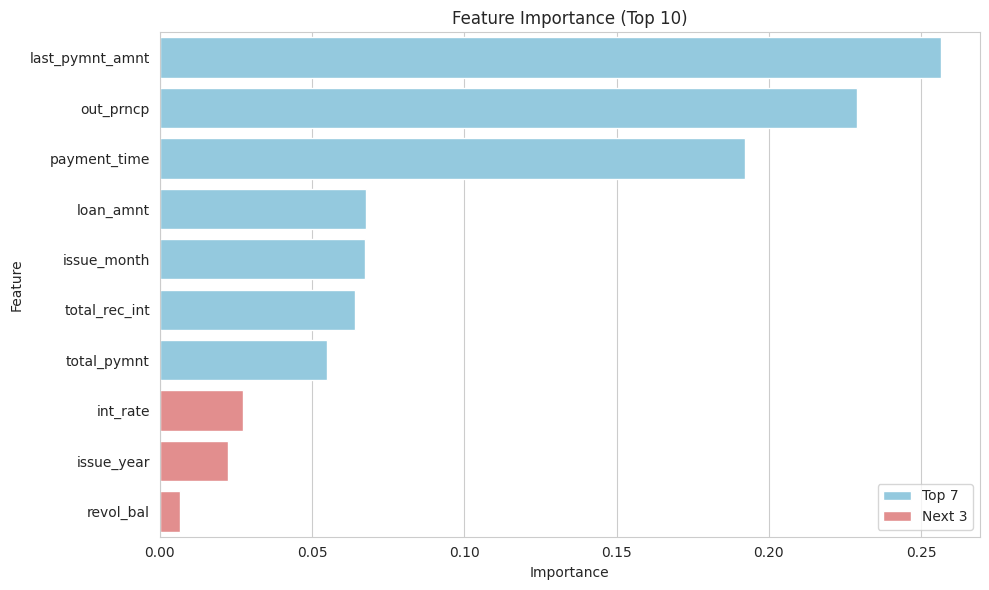

In [ ]:
# Ambil semua 10 fitur
top_10_features = importance_df.head(10)

# Bagi menjadi dua grup: 7 teratas dan 3 sisanya
top_7 = top_10_features.head(7)
next_3 = top_10_features.iloc[7:]

# Buat figure
plt.figure(figsize=(10, 6))

# Barplot untuk 7 teratas
sns.barplot(x='Importance', y='Feature', data=top_7, color='skyblue', label='Top 7')

# Barplot untuk 3 sisanya
sns.barplot(x='Importance', y='Feature', data=next_3, color='lightcoral', label='Next 3')

plt.title('Feature Importance (Top 10)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.legend()
plt.tight_layout()
plt.show()


# **Metrics Impact Simulation**

In [ ]:
# Confusion matrix results
tp = 41065
fp = 19
fn = 691
tn = 4839

# Total before
total_clients = df.shape[0]
total_clients_X = X_scaled.shape[0]
total_low_risk_before = df["loan_status"].value_counts()[0]  # Low-Risk Loan
total_high_risk_before = df["loan_status"].value_counts()[1]  # High-Risk Loan
total_loan = df["funded_amnt"].sum()
avg_loan = total_loan / df.shape[0]

# High-Risk Rate before & after
high_risk_rate_before = total_high_risk_before / total_clients
high_risk_rate_after = (fp + fn) / total_clients_X

# Change in High-Risk Rate
change_high_risk_rate = high_risk_rate_after - high_risk_rate_before

# Total high-risk loans after
total_high_risk_after = high_risk_rate_after * total_clients

# Decrease in high-risk loans
dec_high_risk_loans = total_high_risk_after - total_high_risk_before

# Total revenue, high-risk loss, and net revenue before
tr_before = total_low_risk_before * avg_loan
total_hr_loss_before = total_high_risk_before * avg_loan
net_rev_before = tr_before - total_hr_loss_before

# Total low-risk clients after
total_low_risk_after = total_clients - total_high_risk_after

# Total revenue, high-risk loss, and net revenue after
tr_after = total_low_risk_after * avg_loan
total_hr_loss_after = total_high_risk_after * avg_loan
net_rev_after = tr_after - total_hr_loss_after

# Percentage calculations
perc_dec_high_risk_loans = ((total_high_risk_before - total_high_risk_after) / total_high_risk_before) * 100
perc_inc_total_revenue = ((tr_after - tr_before) / tr_before) * 100
perc_dec_high_risk_loss = ((total_hr_loss_before - total_hr_loss_after) / total_hr_loss_before) * 100
perc_inc_net_revenue = ((net_rev_after - net_rev_before) / net_rev_before) * 100

# Print the results
print(f'Total High-Risk Loans before: {"{:,}".format(total_high_risk_before)}')
print(f'Total High-Risk Loans after: {"{:,}".format(round(total_high_risk_after))}')
print(f'Decrease in High-Risk Loans: {"{:,}".format(round(dec_high_risk_loans))} ({round(perc_dec_high_risk_loans, 2)}%)\n')

print(f'High-Risk Rate before: {round(high_risk_rate_before * 100, 2)}%')
print(f'High-Risk Rate after: {round(high_risk_rate_after * 100, 2)}%')
print(f'Change in High-Risk Rate: {round(change_high_risk_rate * 100, 2)}%\n')

print(f'Total Revenue before: {"{:,}".format(round(tr_before))}')
print(f'Total Revenue after: {"{:,}".format(round(tr_after))}')
print(f'Increase in Total Revenue: {"{:,}".format(round(tr_after - tr_before))} ({round(perc_inc_total_revenue, 2)}%)\n')

print(f'Total High-Risk Loss before: {"{:,}".format(round(total_hr_loss_before))}')
print(f'Total High-Risk Loss after: {"{:,}".format(round(total_hr_loss_after))}')
print(f'Decrease in High-Risk Loss: {"{:,}".format(round(total_hr_loss_before - total_hr_loss_after))} ({round(perc_dec_high_risk_loss, 2)}%)\n')

print(f'Net Revenue before: {"{:,}".format(round(net_rev_before))}')
print(f'Net Revenue after: {"{:,}".format(round(net_rev_after))}')
print(f'Increase in Net Revenue: {"{:,}".format(round(net_rev_after - net_rev_before))} ({round(perc_inc_net_revenue, 2)}%)')


Total High-Risk Loans before: 55,304
Total High-Risk Loans after: 710
Decrease in High-Risk Loans: -54,594 (98.72%)

High-Risk Rate before: 11.86%
High-Risk Rate after: 0.15%
Change in High-Risk Rate: -11.71%

Total Revenue before: 5,872,683,387
Total Revenue after: 6,653,075,750
Increase in Total Revenue: 780,392,363 (13.29%)

Total High-Risk Loss before: 790,541,438
Total High-Risk Loss after: 10,149,075
Decrease in High-Risk Loss: 780,392,363 (98.72%)

Net Revenue before: 5,082,141,950
Net Revenue after: 6,642,926,676
Increase in Net Revenue: 1,560,784,726 (30.71%)


**Business Metrics**

🔹 High-Risk Rate – Default Rate (DR)

Rasio nasabah gagal bayar terhadap total nasabah.

Sebelum: 11.86%

Sesudah: 0.15%

Perubahan: ↓11.71%

🔹 Total High-Risk Loans – Exposure at Default (EAD)

Jumlah pinjaman dari nasabah yang berpotensi gagal bayar.

Sebelum: 55,304

Sesudah: 710

Perubahan: ↓54,594 (↓98.72%)

🔹 Total Revenue – Expected Interest Income

Pendapatan kotor yang dihasilkan dari pinjaman aktif.

Sebelum: Rp 5,872,683,387

Sesudah: Rp 6,653,075,750

Perubahan: ↑Rp 780,392,363 (+13.29%)

🔹 Total High-Risk Loss – Expected Loss (EL)
Potensi kerugian akibat gagal bayar.

Sebelum: 790,541,438

Sesudah: Rp 10,149,075

Perubahan: ↓Rp 780,392,363 (↓98.72%)

🔹 Net Revenue – Net Interest Income (NII)

Pendapatan bersih setelah dikurangi kerugian dari kredit macet.

Sebelum: Rp 5,082,141,950

Sesudah: Rp 6,642,926,676

Perubahan: ↑Rp 1,560,784,726 (+30.71%)

# **Business Recomendation**

**Strategi Bisnis Berbasis Machine Learning untuk Optimasi Risiko Kredit**

Dengan bantuan model XGBoost yang sudah dituning, sistem prediksi risiko kredit kita berhasil menurunkan high-risk loan sebesar 98.72%, meningkatkan total revenue hingga +13.29%, dan mendorong kenaikan net revenue sebesar +30.71%.

Bagaimana kita bisa mempertahankan dan bahkan mengembangkan impact ini secara berkelanjutan?

Berikut 3 Strategi Inti + Insight & Aksi Bisnis Nyata:

### **1. Fast-Track Approval & Loyal Nasabah = Revenue Booster**

 **Insight**: Fitur last_pymnt_amnt, payment_time, dan total_pymnt jadi sinyal paling kuat nasabah dengan riwayat pembayaran sehat. Mereka adalah segmen low-risk yang mendongkrak revenue tanpa menambah risiko.

**Strategi Kekinian:**

*  Implementasi fast-track approval untuk nasabah dengan skor prediksi rendah risiko sehingga proses lebih cepat dan efisiensi tinggi.

*  Tambahkan loyalty rewards seperti cashback, bunga lebih rendah, dan akses eksklusif bagi nasabah disiplin.

* Gunakan gamifikasi (badge pembayaran, leaderboard loyalitas) untuk menjaga engagement tinggi.

**Dampak Real:**

* Meningkatkan konversi pinjaman → kontribusi pada kenaikan revenue +13.29%

* Memperkuat retensi pelanggan sehat → long-term lifetime value

* Hemat waktu dan biaya operasional verifikasi manual

### **2. Smart Monitoring untuk Nasabah Aktif dengan Risiko Tersembunyi**

**Insight**: Fitur out_prncp dan loan_amnt jadi early warning signal. Nasabah dengan pokok tersisa tinggi tapi pembayaran terakhir kecil = potensi gagal bayar tinggi.

**Strategi Kekinian:**

* Buat dashboard monitoring aktif sehingga akun dengan outstanding tinggi langsung ditandai.

* Kirim notifikasi atau reminder otomatis saat ada penurunan pembayaran, sehingga intervensi lebih awal.

* Jalankan AI-based offer: tawarkan restrukturisasi cicilan untuk mencegah default.

**Dampak Real:**

* Penurunan drastis high-risk loans dari 55.304 menjadi 710 (-98.72%)

* High-risk loss turun dari 790M menjadi 10M (-98.72%)

* Turunkan beban operasional dan risiko keuangan

### **3. Dynamic Produk Berdasarkan Pola Pembayaran & Musiman**

**Insight:** Fitur issue_month dan total_rec_int mengindikasikan bahwa waktu pengajuan & struktur bunga ikut mempengaruhi risiko. Ada bulan-bulan rawan yang perlu strategi khusus.

**Strategi Kekinian:**

* Gunakan dynamic credit scoring dengan update real-time berdasarkan payment_time dan bulan pengajuan.

* Hindari promo agresif di bulan-bulan rawan default, ganti dengan promo musiman di periode aman (Q1 misalnya).

* Buat sistem penawaran produk adaptif, sehingga tenor & bunga disesuaikan otomatis dengan histori peminjam.

**Dampak Real:**

* Kurangi potensi gagal bayar karena promo di waktu yang salah

* Optimalkan penetrasi produk pada momen yang terbukti lebih aman

* Naikkan net revenue menjadi +30.71%

Model Machine Learning + Strategi Agile = Transformasi Bisnis Nyata
Kita nggak cuma prediksi siapa yang gagal bayar, tapi juga bisa bentuk perilaku nasabah, desain produk lebih adaptif, dan maksimalkan return dengan minim risiko.

**Turunkan potensi gagal bayar**

**Naikkan efisiensi & kecepatan operasional**

**Dorong revenue & retensi dengan pendekatan yang customer-centric**